Лабораторная работа №3

## Решающее дерево (Decision Tree)

## 2. Создание бейзлайна и оценка качества

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, mean_squared_error, mean_absolute_error, r2_score, 
    classification_report, precision_recall_curve, auc
)
import warnings
warnings.filterwarnings('ignore')

Загрузка данных

In [2]:
# Загрузка данных
df_water = pd.read_csv('water_potability.csv', na_values=['', '?', 'N/A', 'NA', 'None', ' ', '-'], index_col=0)
df_concrete = pd.read_csv('concrete.csv', na_values=['', '?', 'N/A', 'NA', 'None', ' ', '-'])

print(f"Размер данных (вода): {df_water.shape}")
print(f"Размер данных (бетон): {df_concrete.shape}")

Размер данных (вода): (3276, 10)
Размер данных (бетон): (1030, 9)


### 2a. Подготовка данных и обучение baseline моделей

In [3]:
# удаление пропусков для простого baseline
df_water_clean = df_water.dropna()
df_concrete_clean = df_concrete.dropna()

# разделение на признаки и целевую переменную
X_water = df_water_clean.drop('Potability', axis=1)
y_water = df_water_clean['Potability']

X_concrete = df_concrete_clean.iloc[:, :-1]
y_concrete = df_concrete_clean.iloc[:, -1]

# разделение на обучающую и тестовую выборки
X_train_water, X_test_water, y_train_water, y_test_water = train_test_split(
    X_water, y_water, test_size=0.3, random_state=42
)

X_train_concrete, X_test_concrete, y_train_concrete, y_test_concrete = train_test_split(
    X_concrete, y_concrete, test_size=0.3, random_state=42
)

print(f"Классификация - тренировочная: {X_train_water.shape}, тестовая: {X_test_water.shape}")
print(f"Регрессия - тренировочная: {X_train_concrete.shape}, тестовая: {X_test_concrete.shape}")

Классификация - тренировочная: (1407, 9), тестовая: (604, 9)
Регрессия - тренировочная: (721, 8), тестовая: (309, 8)


Обучим базовые модели решающих деревьев на сырых данных без тонкой настройки параметров. Удалим только пропуски, чтобы модель не выдавала ошибку.

In [17]:
# обучение решающего дерева для классификации (baseline)
dt_clf_baseline = DecisionTreeClassifier(random_state=42, max_depth=4)
dt_clf_baseline.fit(X_train_water, y_train_water)
y_pred_water_baseline = dt_clf_baseline.predict(X_test_water)
y_pred_proba_water_baseline = dt_clf_baseline.predict_proba(X_test_water)[:, 1]

# обучение решающего дерева для регрессии (baseline)
dt_reg_baseline = DecisionTreeRegressor(random_state=42, max_depth=4)
dt_reg_baseline.fit(X_train_concrete, y_train_concrete)
y_pred_concrete_baseline = dt_reg_baseline.predict(X_test_concrete)

### 2b. Оценка качества моделей

Выведим и проанализируем метрики для модели классификации.

Метрики качества (Решающее дерево - классификация baseline):
  Accuracy:  0.6043
  Precision: 0.5245
  Recall:    0.4297
  F1-score:  0.4724
  ROC-AUC:   0.6443
  PR-AUC:    0.5574

Матрица ошибок:


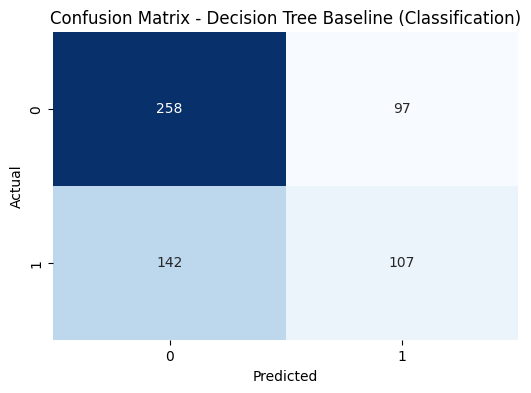


Отчет о классификации:
              precision    recall  f1-score   support

           0       0.65      0.73      0.68       355
           1       0.52      0.43      0.47       249

    accuracy                           0.60       604
   macro avg       0.58      0.58      0.58       604
weighted avg       0.60      0.60      0.60       604



In [18]:
accuracy = accuracy_score(y_test_water, y_pred_water_baseline)
precision = precision_score(y_test_water, y_pred_water_baseline, zero_division=0)
recall = recall_score(y_test_water, y_pred_water_baseline, zero_division=0)
f1 = f1_score(y_test_water, y_pred_water_baseline, zero_division=0)
roc_auc = roc_auc_score(y_test_water, y_pred_proba_water_baseline)
pr_curve = precision_recall_curve(y_test_water, y_pred_proba_water_baseline)
pr_auc = auc(pr_curve[1], pr_curve[0])
cm = confusion_matrix(y_test_water, y_pred_water_baseline)

print(f"Метрики качества (Решающее дерево - классификация baseline):")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-score:  {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")
print(f"  PR-AUC:    {pr_auc:.4f}")

print(f"\nМатрица ошибок:")
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Decision Tree Baseline (Classification)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"\nОтчет о классификации:")
print(classification_report(y_test_water, y_pred_water_baseline))

*При небольшой глубине решающего дерева метрики модели не сильно отличаются от моделей KNN или логистической регрессии. В ходе работы попытаемся подобрать правильную глубину дерева, чтобы модель не переобучилась.*

#### Оценка качества модели регрессии

In [19]:
mse = mean_squared_error(y_test_concrete, y_pred_concrete_baseline)
mae = mean_absolute_error(y_test_concrete, y_pred_concrete_baseline)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_concrete, y_pred_concrete_baseline)

print(f"Метрики качества (Решающее дерево - регрессия baseline):")
print(f"  MSE:  {mse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R²:   {r2:.4f}")

Метрики качества (Решающее дерево - регрессия baseline):
  MSE:  103.1342
  MAE:  7.6459
  RMSE: 10.1555
  R²:   0.6188


*Из-за небольшой глубины решающего дерева метрики модели не сильно отличаются от моделей KNN или линейной регрессии. В ходе работы попытаемся подобрать правильную глубину дерева, чтобы модель не переобучилась.*

#### Визуализация результатов baseline подхода

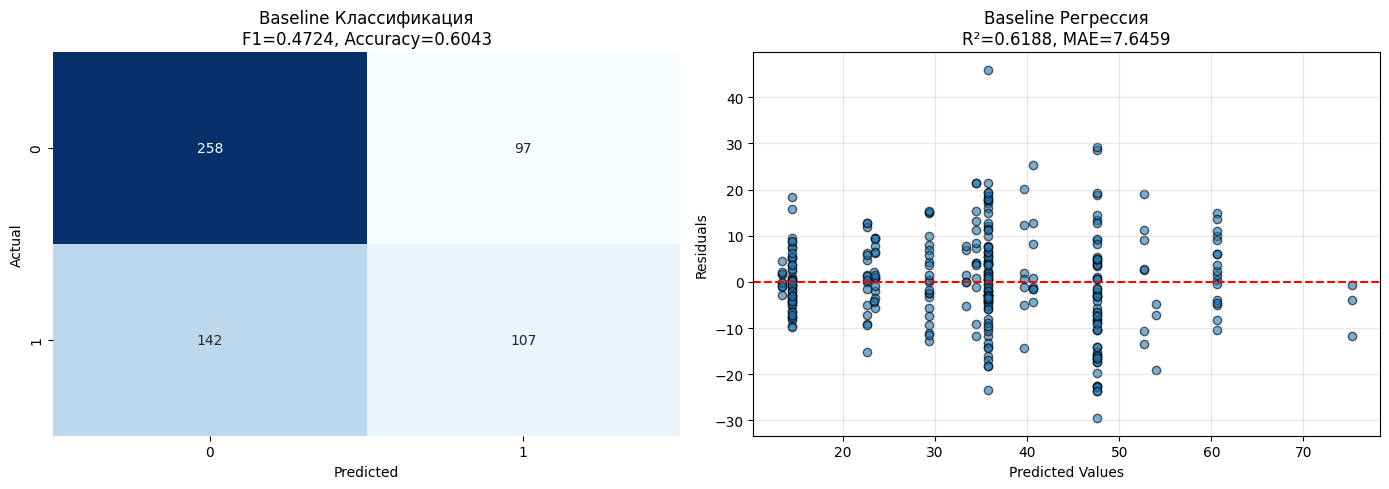

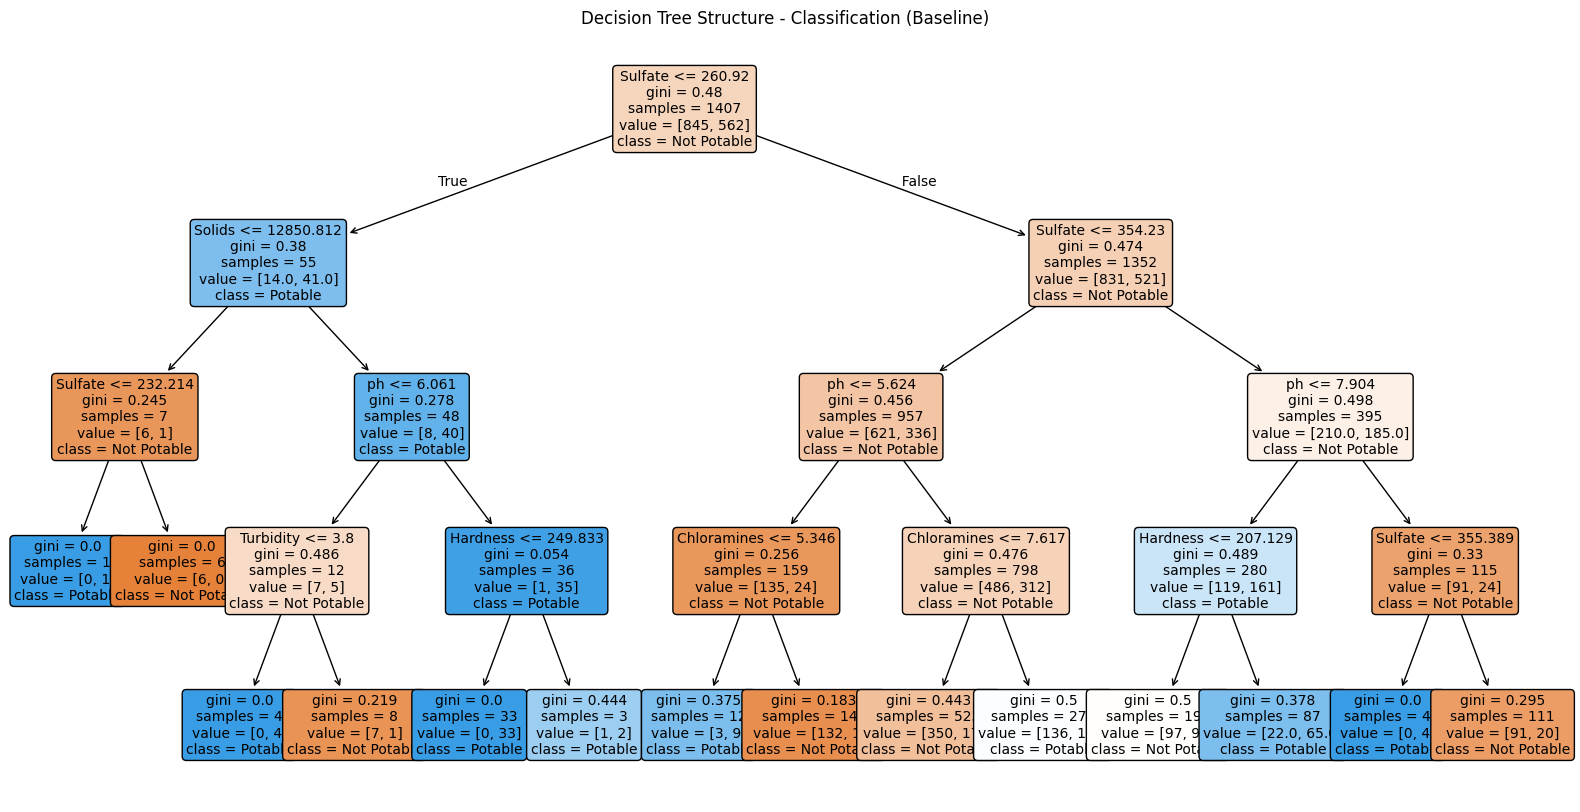

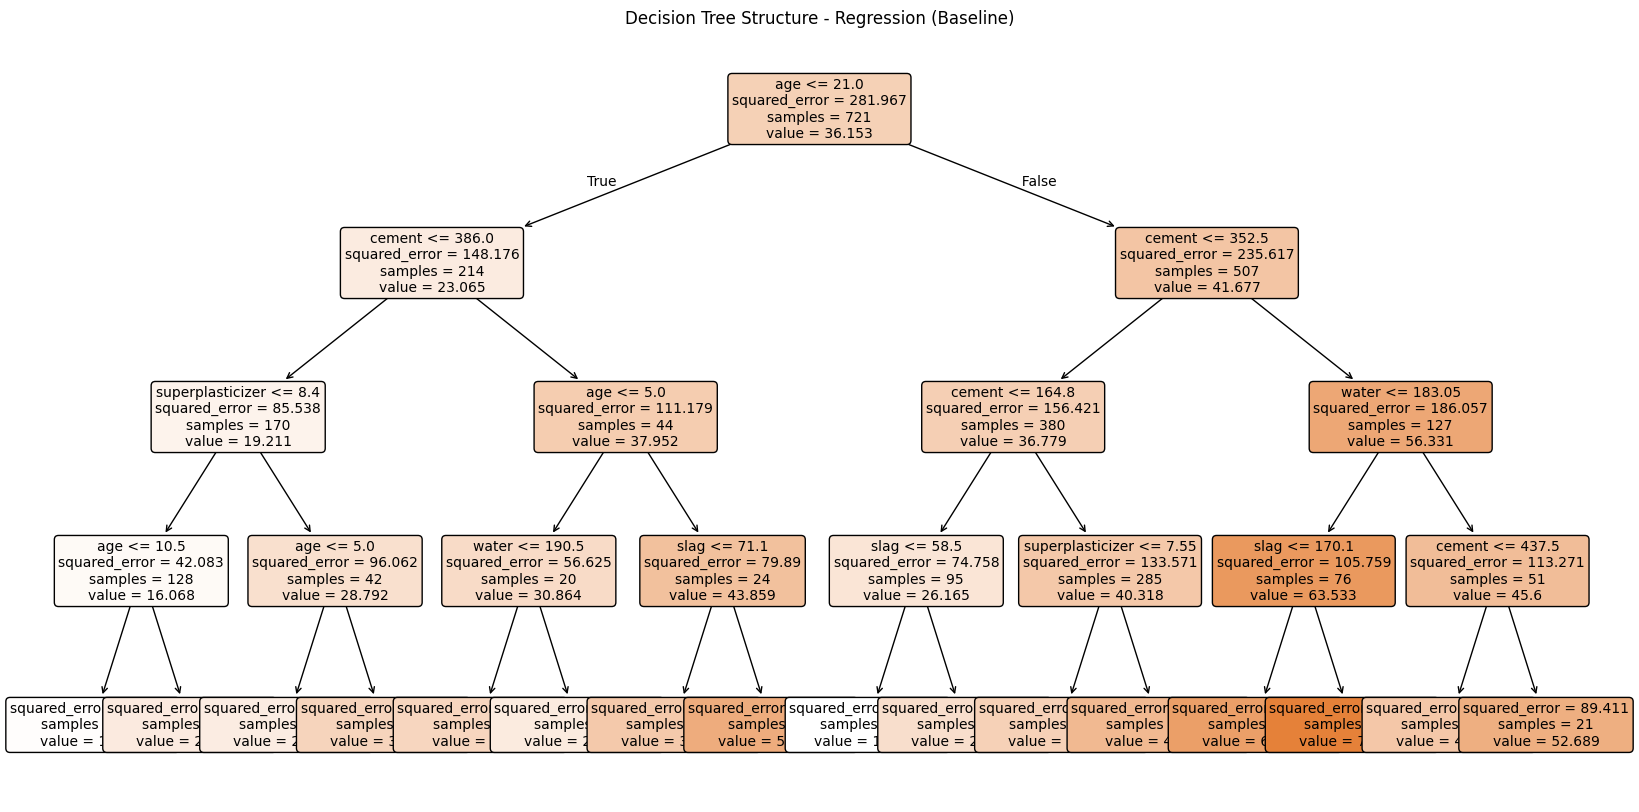

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# матрица ошибок для классификации
cm_baseline_clf = confusion_matrix(y_test_water, y_pred_water_baseline)
sns.heatmap(cm_baseline_clf, annot=True, fmt='d', ax=axes[0], cmap='Blues', cbar=False)
axes[0].set_title(f'Baseline Классификация\nF1={f1:.4f}, Accuracy={accuracy:.4f}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# график остатков для регрессии
residuals_baseline_reg = y_test_concrete - y_pred_concrete_baseline
axes[1].scatter(y_pred_concrete_baseline, residuals_baseline_reg, alpha=0.6, edgecolors='k')
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_title(f'Baseline Регрессия\nR²={r2:.4f}, MAE={mae:.4f}')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Визуализация структуры дерева для классификации
plt.figure(figsize=(20, 10))
plot_tree(dt_clf_baseline, feature_names=X_water.columns, class_names=['Not Potable', 'Potable'], 
          filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree Structure - Classification (Baseline)')
plt.show()

# Визуализация структуры дерева для регрессии
plt.figure(figsize=(20, 10))
plot_tree(dt_reg_baseline, feature_names=X_concrete.columns, 
          filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree Structure - Regression (Baseline)')
plt.show()

## 3. Улучшение бейзлайна

### 3a. Формулирование гипотез улучшения

**Гипотеза 1:** Заполнение пропусков медианой улучшит качество моделей

**Гипотеза 2:** Оптимизация глубины дерева (max_depth) улучшит качество и снизит переобучение

**Гипотеза 3:** Подбор параметров min_samples_split и min_samples_leaf улучшит качество моделей

**Гипотеза 4:** Стандартизация признаков

**Гипотеза 5:** Создание новых признаков улучшит качество модели

### 3b. Проверка гипотез

#### Гипотеза 1: Заполнение пропусков медианой улучшит качество моделей

Проверим гипотезу 1 для классификации

Классификация (с заполнением пропусков):
  Accuracy:  0.7355
  F1-score:  0.5221
  ROC-AUC:   0.8090
  PR-AUC:    0.7543

Метрики качества (Решающее дерево - baseline):
  Accuracy:  0.6043
  F1-score:  0.4724
  ROC-AUC:   0.6443
  PR-AUC:    0.5574


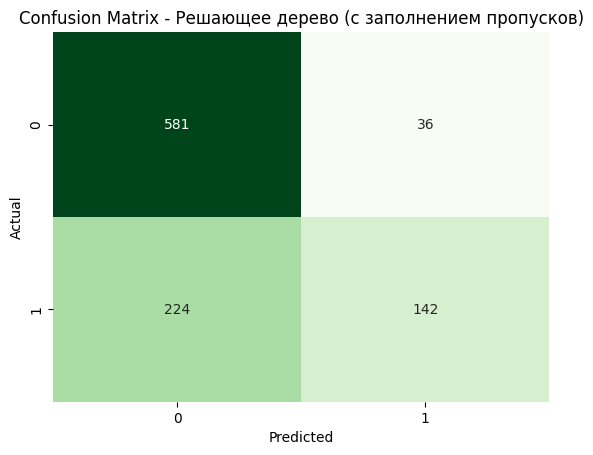

In [40]:
# загрузка данных заново
df_water_hyp1 = pd.read_csv('water_potability.csv', na_values=['', '?', 'N/A', 'NA', 'None', ' ', '-'], index_col=0)

# заполнение пропусков медианой по классам для классификации
df_water_hyp1['ph'] = df_water_hyp1.groupby('Potability')['ph'].transform(lambda x: x.fillna(x.median()))
df_water_hyp1['Sulfate'] = df_water_hyp1.groupby('Potability')['Sulfate'].transform(lambda x: x.fillna(x.median()))
df_water_hyp1['Trihalomethanes'] = df_water_hyp1.groupby('Potability')['Trihalomethanes'].transform(lambda x: x.fillna(x.median()))

# разделение на признаки и целевую переменную
X_water_hyp1 = df_water_hyp1.drop('Potability', axis=1)
y_water_hyp1 = df_water_hyp1['Potability']

# разделение на train/test
X_train_water_h1, X_test_water_h1, y_train_water_h1, y_test_water_h1 = train_test_split(
    X_water_hyp1, y_water_hyp1, test_size=0.3, random_state=42
)

# обучение модели
dt_clf_hyp1 = DecisionTreeClassifier(random_state=42, max_depth=4)
dt_clf_hyp1.fit(X_train_water_h1, y_train_water_h1)
y_pred_water_h1 = dt_clf_hyp1.predict(X_test_water_h1)
y_pred_proba_water_h1 = dt_clf_hyp1.predict_proba(X_test_water_h1)[:, 1]

# метрики для классификации
acc_h1 = accuracy_score(y_test_water_h1, y_pred_water_h1)
f1_h1 = f1_score(y_test_water_h1, y_pred_water_h1, zero_division=0)
roc_auc_h1 = roc_auc_score(y_test_water_h1, y_pred_proba_water_h1)
pr_curve_h1 = precision_recall_curve(y_test_water_h1, y_pred_proba_water_h1)
pr_auc_h1 = auc(pr_curve_h1[1], pr_curve_h1[0])

cm_hyp1 = confusion_matrix(y_test_water_h1, y_pred_water_h1)

print(f"Классификация (с заполнением пропусков):")
print(f"  Accuracy:  {acc_h1:.4f}")
print(f"  F1-score:  {f1_h1:.4f}")
print(f"  ROC-AUC:   {roc_auc_h1:.4f}")
print(f"  PR-AUC:    {pr_auc_h1:.4f}")

print(f"\nМетрики качества (Решающее дерево - baseline):")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  F1-score:  {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")
print(f"  PR-AUC:    {pr_auc:.4f}")

sns.heatmap(cm_hyp1, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix - Решающее дерево (с заполнением пропусков)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

*Видим, что метрики заметно улучшились, но модель сильно ошибается. Стоит отметить, что глубина дерева в beseline и при проверке гипотезы равна 4*

Проверим гипотезу 1 для регрессии. Для регрессии это бесполезно, так как пропусков в данных нет и мы получаем те же метрики.


Регрессия (с заполнением пропусков):
  MAE:  7.6459
  R²:   0.6188
  MSE:  103.1342
Регрессия (Решающее дерево - baseline):
  MAE:  7.6459
  R²:   0.6188
  MSE:  103.1342


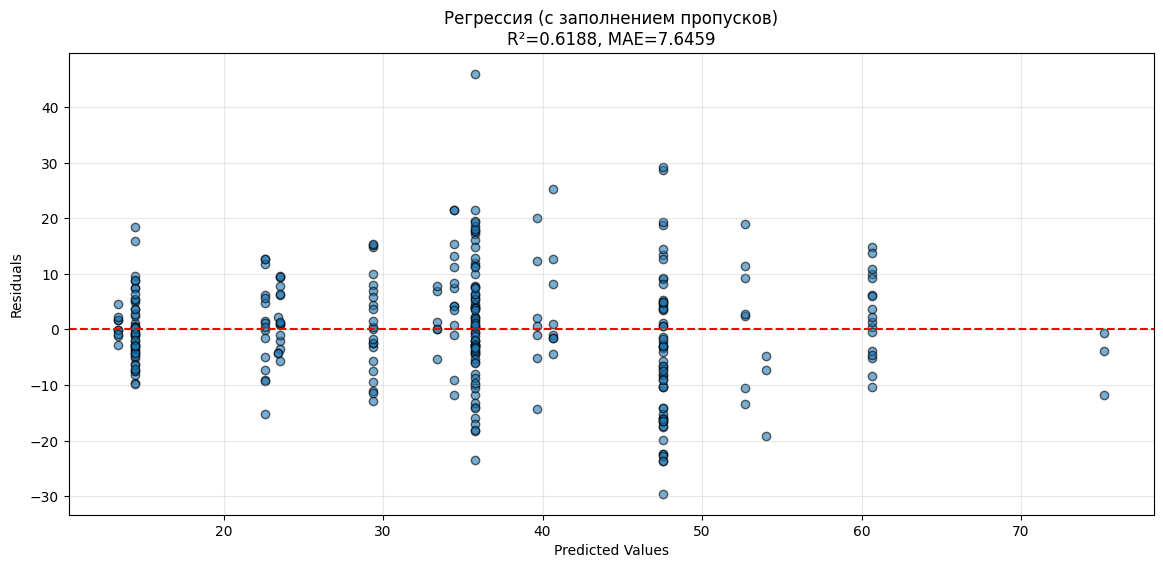

In [41]:
# Для регрессии
df_concrete_hyp1 = pd.read_csv('concrete.csv', na_values=['', '?', 'N/A', 'NA', 'None', ' ', '-'])
df_concrete_hyp1 = df_concrete_hyp1.fillna(df_concrete_hyp1.median())

X_concrete_hyp1 = df_concrete_hyp1.iloc[:, :-1]
y_concrete_hyp1 = df_concrete_hyp1.iloc[:, -1]

X_train_concrete_h1, X_test_concrete_h1, y_train_concrete_h1, y_test_concrete_h1 = train_test_split(
    X_concrete_hyp1, y_concrete_hyp1, test_size=0.3, random_state=42
)

dt_reg_hyp1 = DecisionTreeRegressor(random_state=42, max_depth=4)
dt_reg_hyp1.fit(X_train_concrete_h1, y_train_concrete_h1)
y_pred_concrete_h1 = dt_reg_hyp1.predict(X_test_concrete_h1)

mae_h1 = mean_absolute_error(y_test_concrete_h1, y_pred_concrete_h1)
r2_h1 = r2_score(y_test_concrete_h1, y_pred_concrete_h1)
mse_h1 = mean_squared_error(y_test_concrete_h1, y_pred_concrete_h1)

print(f"\nРегрессия (с заполнением пропусков):")
print(f"  MAE:  {mae_h1:.4f}")
print(f"  R²:   {r2_h1:.4f}")
print(f"  MSE:  {mse_h1:.4f}")

print(f"Регрессия (Решающее дерево - baseline):")
print(f"  MAE:  {mae:.4f}")
print(f"  R²:   {r2:.4f}")
print(f"  MSE:  {mse:.4f}")

fig = plt.figure(figsize=(14, 6))
plt.scatter(y_pred_concrete_h1, y_test_concrete_h1 - y_pred_concrete_h1, alpha=0.6, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'Регрессия (с заполнением пропусков)\nR²={r2_h1:.4f}, MAE={mae_h1:.4f}')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(alpha=0.3)
plt.show()

*Получили аналогичные метрики. Если посмотрим на графики остатков, то увидим, что модель делает одинаковые или очень близкие предсказания, остатки сильно разбросаны от -35 до 40.*

#### Гипотеза 2: Оптимизация глубины дерева

Проверим гипотезу 2 для классификации

Оптимальное max_depth: 5, CV F1-score: 0.8338

Гипотеза 1: Accuracy=0.7355, F1=0.5221, ROC-AUC=0.8090, PR-AUC=0.7543
С оптимальной глубиной 5: Accuracy=0.7579, F1=0.6086, ROC-AUC=0.8257, PR-AUC=0.7676


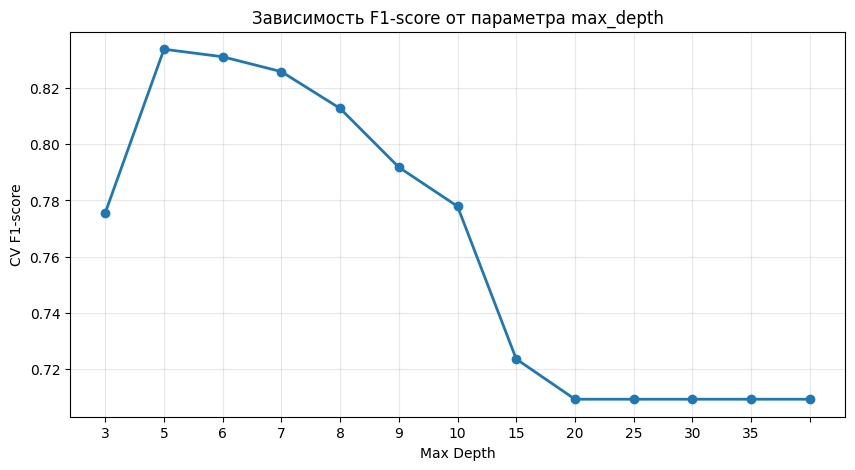

In [45]:
# подбор оптимального параметра max_depth для классификации
max_depths = [3, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, None]
cv_scores_clf = []

for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(dt, X_train_water_h1, y_train_water_h1, cv=5, scoring='roc_auc')
    cv_scores_clf.append(scores.mean())

best_depth = max_depths[np.argmax(cv_scores_clf)]
best_cv_score = max(cv_scores_clf)

print(f"Оптимальное max_depth: {best_depth}, CV F1-score: {best_cv_score:.4f}")

# обучение с оптимальным max_depth
dt_clf_hyp2 = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
dt_clf_hyp2.fit(X_train_water_h1, y_train_water_h1)
y_pred_water_h2 = dt_clf_hyp2.predict(X_test_water_h1)
y_pred_proba_water_h2 = dt_clf_hyp2.predict_proba(X_test_water_h1)[:, 1]

acc_h2 = accuracy_score(y_test_water_h1, y_pred_water_h2)
f1_h2 = f1_score(y_test_water_h1, y_pred_water_h2, zero_division=0)
roc_auc_h2 = roc_auc_score(y_test_water_h1, y_pred_proba_water_h2)
pr_curve_h2 = precision_recall_curve(y_test_water_h1, y_pred_proba_water_h2)
pr_auc_h2 = auc(pr_curve_h2[1], pr_curve_h2[0])
cm_hyp2 = confusion_matrix(y_test_water_h1, y_pred_water_h2)

print(f"\nГипотеза 1: Accuracy={acc_h1:.4f}, F1={f1_h1:.4f}, ROC-AUC={roc_auc_h1:.4f}, PR-AUC={pr_auc_h1:.4f}")
print(f"С оптимальной глубиной {best_depth}: Accuracy={acc_h2:.4f}, F1={f1_h2:.4f}, ROC-AUC={roc_auc_h2:.4f}, PR-AUC={pr_auc_h2:.4f}")

# График зависимости F1 от max_depth
plt.figure(figsize=(10, 5))
plt.plot(range(len(max_depths)), cv_scores_clf, marker='o', linewidth=2, markersize=6)
plt.xlabel('Max Depth')
plt.ylabel('CV F1-score')
plt.title('Зависимость F1-score от параметра max_depth')
plt.xticks(range(len(max_depths)), max_depths)
plt.grid(alpha=0.3)
plt.show()


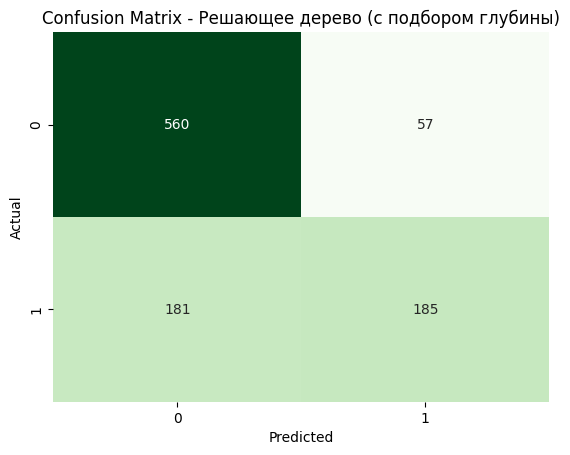

In [44]:
sns.heatmap(cm_hyp2, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix - Решающее дерево (с подбором глубины)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

*После подбора глубины метрики улучшились, но незначительно. Матрица ошибок показывает, что модель все еще ошибается.*


Регрессия - Оптимальное max_depth: 20, CV R²: 0.8075
Гипотеза 1: MAE=7.6459, R²=0.6188, MSE=103.1342
С оптимальной глубиной 20: MAE=4.4604, R²=0.8252, MSE=47.2904


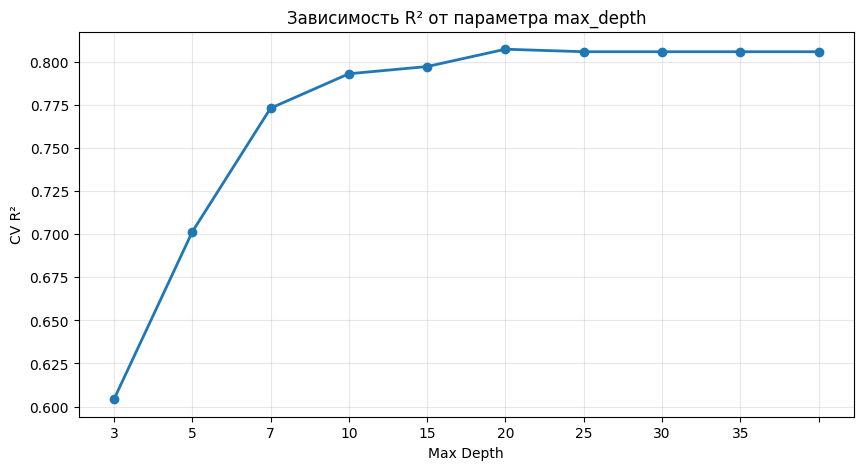

In [ ]:
max_depths_reg = [3, 5, 7, 10, 15, 20,25, 30, 35, None]
cv_scores_reg = []

for depth in max_depths_reg:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
    scores = cross_val_score(dt, X_train_concrete_h1, y_train_concrete_h1, cv=5, scoring='r2')
    cv_scores_reg.append(scores.mean())

best_depth_reg = max_depths_reg[np.argmax(cv_scores_reg)]
best_cv_score_reg = max(cv_scores_reg)

print(f"\nРегрессия - Оптимальное max_depth: {best_depth_reg}, CV R²: {best_cv_score_reg:.4f}")

dt_reg_hyp2 = DecisionTreeRegressor(max_depth=best_depth_reg, random_state=42)
dt_reg_hyp2.fit(X_train_concrete_h1, y_train_concrete_h1)
y_pred_concrete_h2 = dt_reg_hyp2.predict(X_test_concrete_h1)

mae_h2 = mean_absolute_error(y_test_concrete_h1, y_pred_concrete_h2)
r2_h2 = r2_score(y_test_concrete_h1, y_pred_concrete_h2)
mse_h2 = mean_squared_error(y_test_concrete_h1, y_pred_concrete_h2)
rmse_h2 = np.sqrt(mse_h2)

print(f"Гипотеза 1: MAE={mae_h1:.4f}, R²={r2_h1:.4f}, MSE={mse_h1:.4f}")
print(f"С оптимальной глубиной {best_depth_reg}: MAE={mae_h2:.4f}, R²={r2_h2:.4f}, MSE={mse_h2:.4f}")

# График зависимости R^2 от max_depth
plt.figure(figsize=(10, 5))
plt.plot(range(len(max_depths_reg)), cv_scores_reg, marker='o', linewidth=2, markersize=6)
plt.xlabel('Max Depth')
plt.ylabel('CV R²')
plt.title('Зависимость R² от параметра max_depth')
plt.xticks(range(len(max_depths_reg)), max_depths_reg)
plt.grid(alpha=0.3)
plt.show()

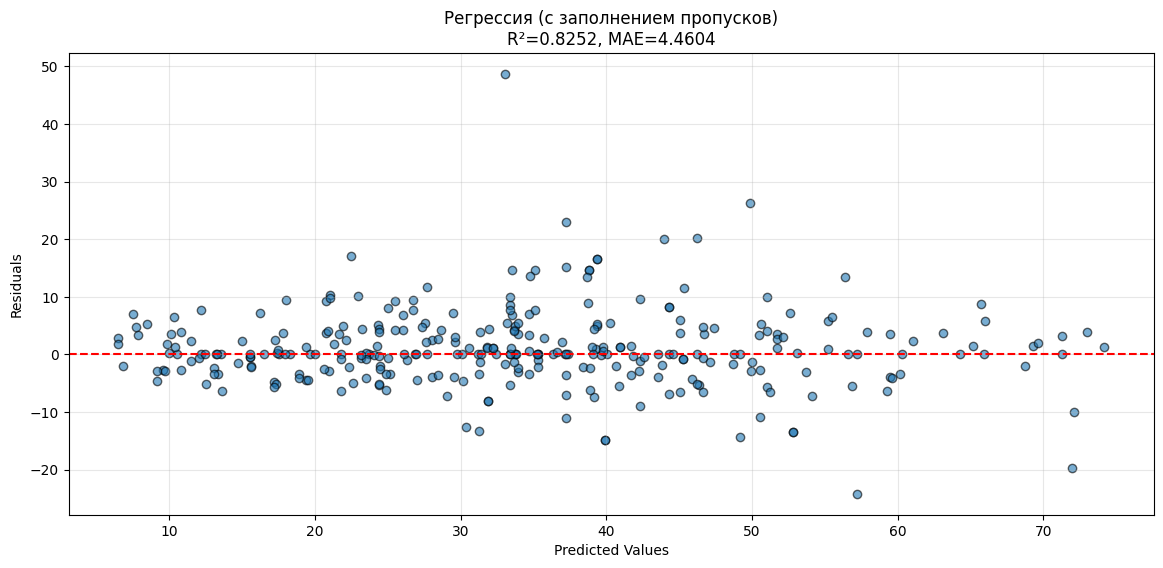

In [47]:
fig = plt.figure(figsize=(14, 6))
plt.scatter(y_pred_concrete_h2, y_test_concrete_h1 - y_pred_concrete_h2, alpha=0.6, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'Регрессия (с заполнением пропусков)\nR²={r2_h2:.4f}, MAE={mae_h2:.4f}')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(alpha=0.3)
plt.show()

*После подбора грубины метрики регрессии значительно улучшились. Разброс значений на графиках остатков уменьшился и стал от -20 до 20. Модель стала лучше предсказывать.*

#### Гипотеза 3: Подбор параметров min_samples_split и min_samples_leaf

Проверим гипотезу 3 для классификации

Оптимальные параметры для классификации:
  min_samples_split: 20
  min_samples_leaf: 4
  CV F1-score: 0.6458

Гипотеза 2 (max_depth=5): Accuracy=0.7579, F1=0.6086, ROC-AUC=0.8257, PR-AUC=0.7676
Гипотеза 3 (opt params): Accuracy=0.7609, F1=0.6129, ROC-AUC=0.8306, PR-AUC=0.7760


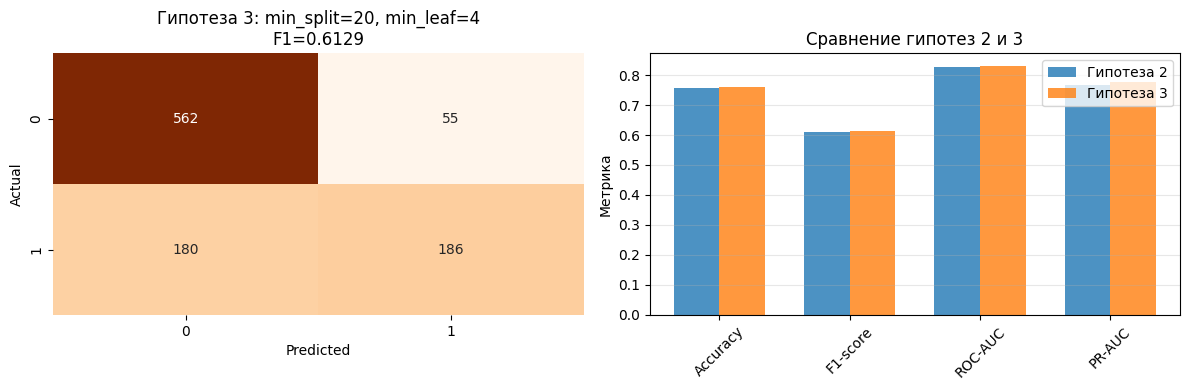

In [ ]:
# подбор оптимальных параметров min_samples_split и min_samples_leaf для классификации
min_samples_split_values = [2, 5, 10, 15, 20]
min_samples_leaf_values = [1, 2, 4, 8]

best_f1_hyp3 = -1
best_min_split = None
best_min_leaf = None
results_hyp3 = []

for min_split in min_samples_split_values:
    for min_leaf in min_samples_leaf_values:
        dt = DecisionTreeClassifier(
            max_depth=best_depth,
            min_samples_split=min_split,
            min_samples_leaf=min_leaf,
            random_state=42
        )
        scores = cross_val_score(dt, X_train_water_h1, y_train_water_h1, cv=5, scoring='f1')
        mean_f1 = scores.mean()
        results_hyp3.append({
            'min_split': min_split,
            'min_leaf': min_leaf,
            'f1': mean_f1
        })
        
        if mean_f1 > best_f1_hyp3:
            best_f1_hyp3 = mean_f1
            best_min_split = min_split
            best_min_leaf = min_leaf

print(f"Оптимальные параметры для классификации:")
print(f"  min_samples_split: {best_min_split}")
print(f"  min_samples_leaf: {best_min_leaf}")
print(f"  CV F1-score: {best_f1_hyp3:.4f}")

# обучение модели с оптимальными параметрами
dt_clf_hyp3 = DecisionTreeClassifier(
    max_depth=best_depth,
    min_samples_split=best_min_split,
    min_samples_leaf=best_min_leaf,
    random_state=42
)
dt_clf_hyp3.fit(X_train_water_h1, y_train_water_h1)
y_pred_water_h3 = dt_clf_hyp3.predict(X_test_water_h1)
y_pred_proba_water_h3 = dt_clf_hyp3.predict_proba(X_test_water_h1)[:, 1]

acc_h3 = accuracy_score(y_test_water_h1, y_pred_water_h3)
f1_h3 = f1_score(y_test_water_h1, y_pred_water_h3, zero_division=0)
roc_auc_h3 = roc_auc_score(y_test_water_h1, y_pred_proba_water_h3)
pr_curve_h3 = precision_recall_curve(y_test_water_h1, y_pred_proba_water_h3)
pr_auc_h3 = auc(pr_curve_h3[1], pr_curve_h3[0])
cm_hyp3 = confusion_matrix(y_test_water_h1, y_pred_water_h3)

print(f"\nГипотеза 2 (max_depth={best_depth}): Accuracy={acc_h2:.4f}, F1={f1_h2:.4f}, ROC-AUC={roc_auc_h2:.4f}, PR-AUC={pr_auc_h2:.4f}")
print(f"Гипотеза 3 (opt params): Accuracy={acc_h3:.4f}, F1={f1_h3:.4f}, ROC-AUC={roc_auc_h3:.4f}, PR-AUC={pr_auc_h3:.4f}")

# визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# матрица ошибок
sns.heatmap(cm_hyp3, annot=True, fmt='d', ax=axes[0], cmap='Oranges', cbar=False)
axes[0].set_title(f'Гипотеза 3: min_split={best_min_split}, min_leaf={best_min_leaf}\nF1={f1_h3:.4f}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# сравнение метрик
metrics_names = ['Accuracy', 'F1-score', 'ROC-AUC', 'PR-AUC']
hyp2_metrics = [acc_h2, f1_h2, roc_auc_h2, pr_auc_h2]
hyp3_metrics = [acc_h3, f1_h3, roc_auc_h3, pr_auc_h3]

x = np.arange(len(metrics_names))
width = 0.35

axes[1].bar(x - width/2, hyp2_metrics, width, label='Гипотеза 2', alpha=0.8)
axes[1].bar(x + width/2, hyp3_metrics, width, label='Гипотеза 3', alpha=0.8)
axes[1].set_ylabel('Метрика')
axes[1].set_title('Сравнение гипотез 2 и 3')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_names, rotation=45)
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

*Подбор оптимальных параметров улучшил метрики модели классификации, но не значительно.*

Проверим гипотезу 3 для регрессии

Оптимальные параметры для регрессии:
  min_samples_split: 2
  min_samples_leaf: 1
  CV R²: 0.8075

Гипотеза 2 (max_depth=20): MAE=4.4604, R²=0.8252, RMSE=6.8768
Гипотеза 3 (opt params): MAE=4.4604, R²=0.8252, RMSE=6.8768


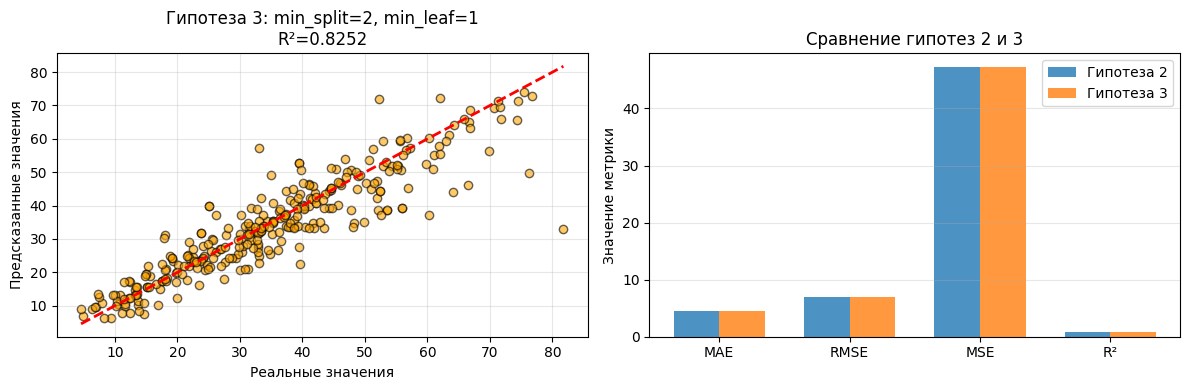

In [ ]:
# Подбор оптимальных параметров min_samples_split и min_samples_leaf для регрессии
min_samples_split_values = [2, 5, 10, 15, 20]
min_samples_leaf_values = [1, 2, 4, 8]

best_r2_hyp3_reg = -1
best_min_split_reg = None
best_min_leaf_reg = None
results_hyp3_reg = []

for min_split in min_samples_split_values:
    for min_leaf in min_samples_leaf_values:
        dt = DecisionTreeRegressor(
            max_depth=best_depth_reg,
            min_samples_split=min_split,
            min_samples_leaf=min_leaf,
            random_state=42
        )
        scores = cross_val_score(dt, X_train_concrete_h1, y_train_concrete_h1, cv=5, scoring='r2')
        mean_r2 = scores.mean()
        results_hyp3_reg.append({
            'min_split': min_split,
            'min_leaf': min_leaf,
            'r2': mean_r2
        })
        
        if mean_r2 > best_r2_hyp3_reg:
            best_r2_hyp3_reg = mean_r2
            best_min_split_reg = min_split
            best_min_leaf_reg = min_leaf

print(f"Оптимальные параметры для регрессии:")
print(f"  min_samples_split: {best_min_split_reg}")
print(f"  min_samples_leaf: {best_min_leaf_reg}")
print(f"  CV R²: {best_r2_hyp3_reg:.4f}")

# Обучение модели с оптимальными параметрами
dt_reg_hyp3 = DecisionTreeRegressor(
    max_depth=best_depth_reg,
    min_samples_split=best_min_split_reg,
    min_samples_leaf=best_min_leaf_reg,
    random_state=42
)
dt_reg_hyp3.fit(X_train_concrete_h1, y_train_concrete_h1)
y_pred_concrete_h3 = dt_reg_hyp3.predict(X_test_concrete_h1)

mae_h3_reg = mean_absolute_error(y_test_concrete_h1, y_pred_concrete_h3)
rmse_h3_reg = np.sqrt(mean_squared_error(y_test_concrete_h1, y_pred_concrete_h3))
mse_h3_reg = mean_squared_error(y_test_concrete_h1, y_pred_concrete_h3)
r2_h3_reg = r2_score(y_test_concrete_h1, y_pred_concrete_h3)

print(f"\nГипотеза 2 (max_depth={best_depth_reg}): MAE={mae_h2:.4f}, R²={r2_h2:.4f}, RMSE={rmse_h2:.4f}")
print(f"Гипотеза 3 (opt params): MAE={mae_h3_reg:.4f}, R²={r2_h3_reg:.4f}, RMSE={rmse_h3_reg:.4f}")

# Визуализация результатов для регрессии
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# График предсказаний vs реальные значения
axes[0].scatter(y_test_concrete_h1, y_pred_concrete_h3, alpha=0.6, edgecolors='k', color='orange')
axes[0].plot([y_test_concrete_h1.min(), y_test_concrete_h1.max()], 
            [y_test_concrete_h1.min(), y_test_concrete_h1.max()], 'r--', lw=2)
axes[0].set_xlabel('Реальные значения')
axes[0].set_ylabel('Предсказанные значения')
axes[0].set_title(f'Гипотеза 3: min_split={best_min_split_reg}, min_leaf={best_min_leaf_reg}\nR²={r2_h3_reg:.4f}')
axes[0].grid(alpha=0.3)

# Сравнение метрик
metrics_names_reg = ['MAE', 'RMSE', 'MSE', 'R²']
hyp2_metrics_reg = [mae_h2, rmse_h2, mse_h2, r2_h2]
hyp3_metrics_reg = [mae_h3_reg, rmse_h3_reg, mse_h3_reg, r2_h3_reg]

x = np.arange(len(metrics_names_reg))
width = 0.35

axes[1].bar(x - width / 2, hyp2_metrics_reg, width, label='Гипотеза 2', alpha=0.8)
axes[1].bar(x + width / 2, hyp3_metrics_reg, width, label='Гипотеза 3', alpha=0.8)
axes[1].set_ylabel('Значение метрики')
axes[1].set_title('Сравнение гипотез 2 и 3')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_names_reg)
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


*По сравнению с гипотезой 2 метрики не изменились, для регрессии гипотеза не дала улучшений.*

#### Гипотеза 4: Стандартизация признаков

Проверим гипотезу 4 для классификации


Гипотеза 3 (opt params): Accuracy=0.7609, F1=0.6129, ROC-AUC=0.8306, PR-AUC=0.7760
Гипотеза 4 (Масштабирование): Accuracy=0.7609, F1=0.6129, ROC-AUC=0.8306, PR-AUC=0.7760


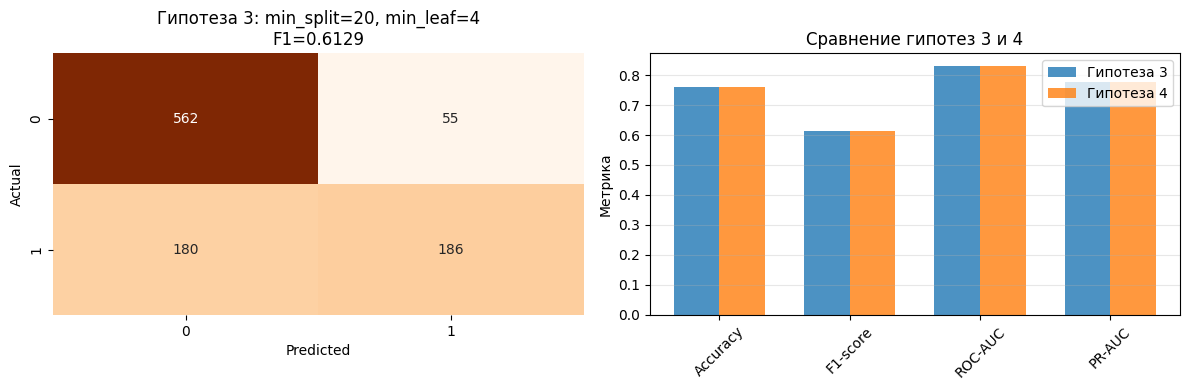

In [66]:
best_min_split = 20
best_min_leaf = 4

scaler = StandardScaler()
X_train_water_sc = scaler.fit_transform(X_train_water_h1)
X_test_water_sc = scaler.transform(X_test_water_h1)


# Обучение модели с оптимальными параметрами
dt_clf_hyp4 = DecisionTreeClassifier(
    max_depth=best_depth,
    min_samples_split=best_min_split,
    min_samples_leaf=best_min_leaf,
    random_state=42
)
dt_clf_hyp4.fit(X_train_water_sc, y_train_water_h1)
y_pred_water_h4 = dt_clf_hyp4.predict(X_test_water_sc)
y_pred_proba_water_h4 = dt_clf_hyp4.predict_proba(X_test_water_sc)[:, 1]

acc_h4 = accuracy_score(y_test_water_h1, y_pred_water_h4)
f1_h4 = f1_score(y_test_water_h1, y_pred_water_h4, zero_division=0)
roc_auc_h4 = roc_auc_score(y_test_water_h1, y_pred_proba_water_h4)
pr_curve_h4 = precision_recall_curve(y_test_water_h1, y_pred_proba_water_h4)
pr_auc_h4 = auc(pr_curve_h4[1], pr_curve_h4[0])
cm_hyp4 = confusion_matrix(y_test_water_h1, y_pred_water_h4)
print(f"\nГипотеза 3 (opt params): Accuracy={acc_h3:.4f}, F1={f1_h3:.4f}, ROC-AUC={roc_auc_h3:.4f}, PR-AUC={pr_auc_h3:.4f}")
print(f"Гипотеза 4 (Масштабирование): Accuracy={acc_h4:.4f}, F1={f1_h4:.4f}, ROC-AUC={roc_auc_h4:.4f}, PR-AUC={pr_auc_h4:.4f}")

# Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Матрица ошибок
sns.heatmap(cm_hyp3, annot=True, fmt='d', ax=axes[0], cmap='Oranges', cbar=False)
axes[0].set_title(f'Гипотеза 3: min_split={best_min_split}, min_leaf={best_min_leaf}\nF1={f1_h3:.4f}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Сравнение метрик
metrics_names = ['Accuracy', 'F1-score', 'ROC-AUC', 'PR-AUC']
hyp3_metrics = [acc_h3, f1_h3, roc_auc_h3, pr_auc_h3]
hyp4_metrics = [acc_h4, f1_h4, roc_auc_h4, pr_auc_h4]

x = np.arange(len(metrics_names))
width = 0.35

axes[1].bar(x - width/2, hyp3_metrics, width, label='Гипотеза 3', alpha=0.8)
axes[1].bar(x + width/2, hyp4_metrics, width, label='Гипотеза 4', alpha=0.8)
axes[1].set_ylabel('Метрика')
axes[1].set_title('Сравнение гипотез 3 и 4')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_names, rotation=45)
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


*Стандартизация не улучшила метрики модели классификации.*

Проверим гипотезу 3 для регрессии


Гипотеза 3 (opt params): MAE=4.4604, R²=0.8252, RMSE=6.8768
Гипотеза 4 (opt params): MAE=4.5777, R²=0.8271, RMSE=6.8402


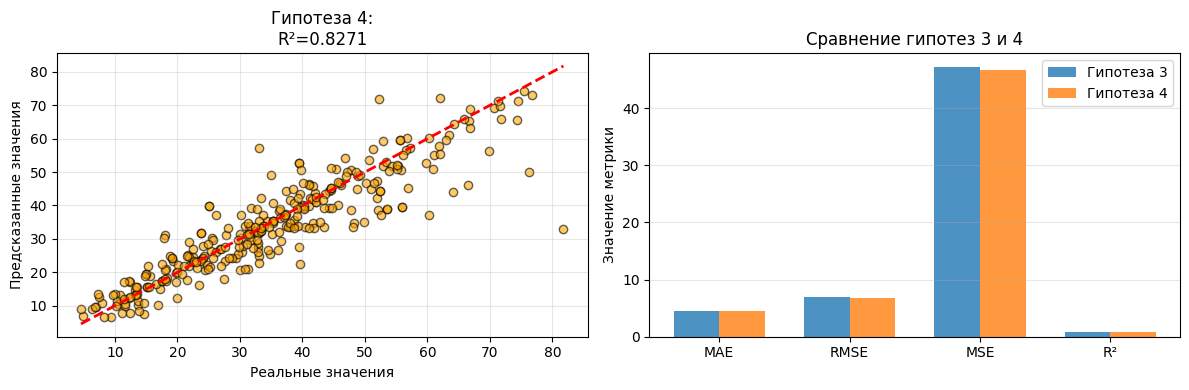

In [67]:

best_min_split_reg = 4
best_min_leaf_reg = 1

scaler_reg = StandardScaler()
X_train_concrete_sc = scaler_reg.fit_transform(X_train_concrete_h1)
X_test_concrete_sc = scaler_reg.transform(X_test_concrete_h1)


# Обучение модели с оптимальными параметрами
dt_reg_hyp4 = DecisionTreeRegressor(
    max_depth=best_depth_reg,
    min_samples_split=best_min_split_reg,
    min_samples_leaf=best_min_leaf_reg,
    random_state=42
)
dt_reg_hyp4.fit(X_train_concrete_sc, y_train_concrete_h1)
y_pred_concrete_h4 = dt_reg_hyp4.predict(X_test_concrete_sc)

mae_h4_reg = mean_absolute_error(y_test_concrete_h1, y_pred_concrete_h4)
rmse_h4_reg = np.sqrt(mean_squared_error(y_test_concrete_h1, y_pred_concrete_h4))
mse_h4_reg = mean_squared_error(y_test_concrete_h1, y_pred_concrete_h4)
r2_h4_reg = r2_score(y_test_concrete_h1, y_pred_concrete_h4)

print(f"\nГипотеза 3 (opt params): MAE={mae_h3_reg:.4f}, R²={r2_h3_reg:.4f}, RMSE={rmse_h3_reg:.4f}")
print(f"Гипотеза 4 (opt params): MAE={mae_h4_reg:.4f}, R²={r2_h4_reg:.4f}, RMSE={rmse_h4_reg:.4f}")
    
# Визуализация результатов для регрессии
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# График предсказаний vs реальные значения
axes[0].scatter(y_test_concrete_h1, y_pred_concrete_h3, alpha=0.6, edgecolors='k', color='orange')
axes[0].plot([y_test_concrete_h1.min(), y_test_concrete_h1.max()], 
            [y_test_concrete_h1.min(), y_test_concrete_h1.max()], 'r--', lw=2)
axes[0].set_xlabel('Реальные значения')
axes[0].set_ylabel('Предсказанные значения')
axes[0].set_title(f'Гипотеза 4:\nR²={r2_h4_reg:.4f}')
axes[0].grid(alpha=0.3)

# Сравнение метрик
metrics_names_reg = ['MAE', 'RMSE', 'MSE', 'R²']
hyp3_metrics_reg = [mae_h3_reg, rmse_h3_reg, mse_h3_reg, r2_h3_reg]
hyp4_metrics_reg = [mae_h4_reg, rmse_h4_reg, mse_h4_reg, r2_h4_reg]

x = np.arange(len(metrics_names_reg))
width = 0.35

axes[1].bar(x - width / 2, hyp3_metrics_reg, width, label='Гипотеза 3', alpha=0.8)
axes[1].bar(x + width / 2, hyp4_metrics_reg, width, label='Гипотеза 4', alpha=0.8)
axes[1].set_ylabel('Значение метрики')
axes[1].set_title('Сравнение гипотез 3 и 4')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_names_reg)
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


*Стандартизация не улучшила метрики модели регрессии.*

#### Гипотеза 5: Создание новых признаков

Создание новых признаков для задачи классификации.

In [48]:
# загрузим данные заново для инженерии признаков
df_water_fe = pd.read_csv('water_potability.csv', na_values=['', '?', 'N/A', 'NA', 'None', ' ', '-'], index_col=0)

# заполнение пропусков медианой по классам
df_water_fe['ph'] = df_water_fe.groupby('Potability')['ph'].transform(lambda x: x.fillna(x.median()))
df_water_fe['Sulfate'] = df_water_fe.groupby('Potability')['Sulfate'].transform(lambda x: x.fillna(x.median()))
df_water_fe['Trihalomethanes'] = df_water_fe.groupby('Potability')['Trihalomethanes'].transform(lambda x: x.fillna(x.median()))

# разделяем на признаки и целевую переменную
X_water_fe = df_water_fe.drop('Potability', axis=1)
y_water_fe = df_water_fe['Potability']

# создание новых признаков
X_water_fe_extended = X_water_fe.copy()

# 1. взаимодействие признаков
X_water_fe_extended['ph_sulfate'] = X_water_fe_extended['ph'] * X_water_fe_extended['Sulfate']
X_water_fe_extended['ph_turbidity'] = X_water_fe_extended['ph'] * X_water_fe_extended['Turbidity']
X_water_fe_extended['conductivity_sulfate'] = X_water_fe_extended['Conductivity'] * X_water_fe_extended['Sulfate']

# 2. полиномиальные признаки
X_water_fe_extended['ph_squared'] = X_water_fe_extended['ph'] ** 2
X_water_fe_extended['conductivity_squared'] = X_water_fe_extended['Conductivity'] ** 2
X_water_fe_extended['organic_carbon_squared'] = X_water_fe_extended['Organic_carbon'] ** 2

# 3. статистические признаки
X_water_fe_extended['feature_mean'] = X_water_fe_extended.mean(axis=1)
X_water_fe_extended['feature_std'] = X_water_fe_extended.std(axis=1)
X_water_fe_extended['feature_max'] = X_water_fe_extended.max(axis=1)
X_water_fe_extended['feature_min'] = X_water_fe_extended.min(axis=1)

# 4. отношения между признаками (безопасность - деление на ноль)
X_water_fe_extended['ph_conductivity_ratio'] = X_water_fe_extended['ph'] / (X_water_fe_extended['Conductivity'] + 1e-6)
X_water_fe_extended['sulfate_turbidity_ratio'] = X_water_fe_extended['Sulfate'] / (X_water_fe_extended['Turbidity'] + 1e-6)

print(f"Исходное количество признаков: {X_water_fe.shape[1]}")
print(f"Количество признаков после инженерии: {X_water_fe_extended.shape[1]}")
print(f"\nНовые признаки: {list(X_water_fe_extended.columns[X_water_fe.shape[1]:])}")

Исходное количество признаков: 9
Количество признаков после инженерии: 21

Новые признаки: ['ph_sulfate', 'ph_turbidity', 'conductivity_sulfate', 'ph_squared', 'conductivity_squared', 'organic_carbon_squared', 'feature_mean', 'feature_std', 'feature_max', 'feature_min', 'ph_conductivity_ratio', 'sulfate_turbidity_ratio']


Обучение модели с новыми признаками

In [69]:
# разделение на train/test с новыми признаками
X_train_water_fe, X_test_water_fe, y_train_water_fe, y_test_water_fe = train_test_split(
    X_water_fe_extended, y_water_fe, test_size=0.3, random_state=42
)

# обучение решающего дерева с новыми признаками и оптимальной глубиной
dt_clf_fe = DecisionTreeClassifier(max_depth=best_depth, random_state=42, min_samples_split=20, min_samples_leaf=4)
dt_clf_fe.fit(X_train_water_fe, y_train_water_fe)
y_pred_water_fe = dt_clf_fe.predict(X_test_water_fe)
y_pred_proba_water_fe = dt_clf_fe.predict_proba(X_test_water_fe)[:, 1]

# вычисление метрик
acc_fe = accuracy_score(y_test_water_fe, y_pred_water_fe)
f1_fe = f1_score(y_test_water_fe, y_pred_water_fe, zero_division=0)
roc_auc_fe = roc_auc_score(y_test_water_fe, y_pred_proba_water_fe)
pr_curve_fe = precision_recall_curve(y_test_water_fe, y_pred_proba_water_fe)
pr_auc_fe = auc(pr_curve_fe[1], pr_curve_fe[0])
precision_fe = precision_score(y_test_water_fe, y_pred_water_fe, zero_division=0)
recall_fe = recall_score(y_test_water_fe, y_pred_water_fe, zero_division=0)

print(f"Метрики качества (с новыми признаками):")
print(f"  Accuracy:  {acc_fe:.4f}")
print(f"  Precision: {precision_fe:.4f}")
print(f"  Recall:    {recall_fe:.4f}")
print(f"  F1-score:  {f1_fe:.4f}")
print(f"  ROC-AUC:   {roc_auc_fe:.4f}")
print(f"  PR-AUC:    {pr_auc_fe:.4f}")

print(f"\nМетрики качества (Гипотеза 3):")
print(f"  Accuracy:  {acc_h3:.4f}")
print(f"  F1-score:  {f1_h3:.4f}")
print(f"  ROC-AUC:   {roc_auc_h3:.4f}")
print(f"  PR-AUC:    {pr_auc_h3:.4f}")

Метрики качества (с новыми признаками):
  Accuracy:  0.7548
  Precision: 0.7593
  Recall:    0.5000
  F1-score:  0.6030
  ROC-AUC:   0.8229
  PR-AUC:    0.7605

Метрики качества (Гипотеза 3):
  Accuracy:  0.7609
  F1-score:  0.6129
  ROC-AUC:   0.8306
  PR-AUC:    0.7760


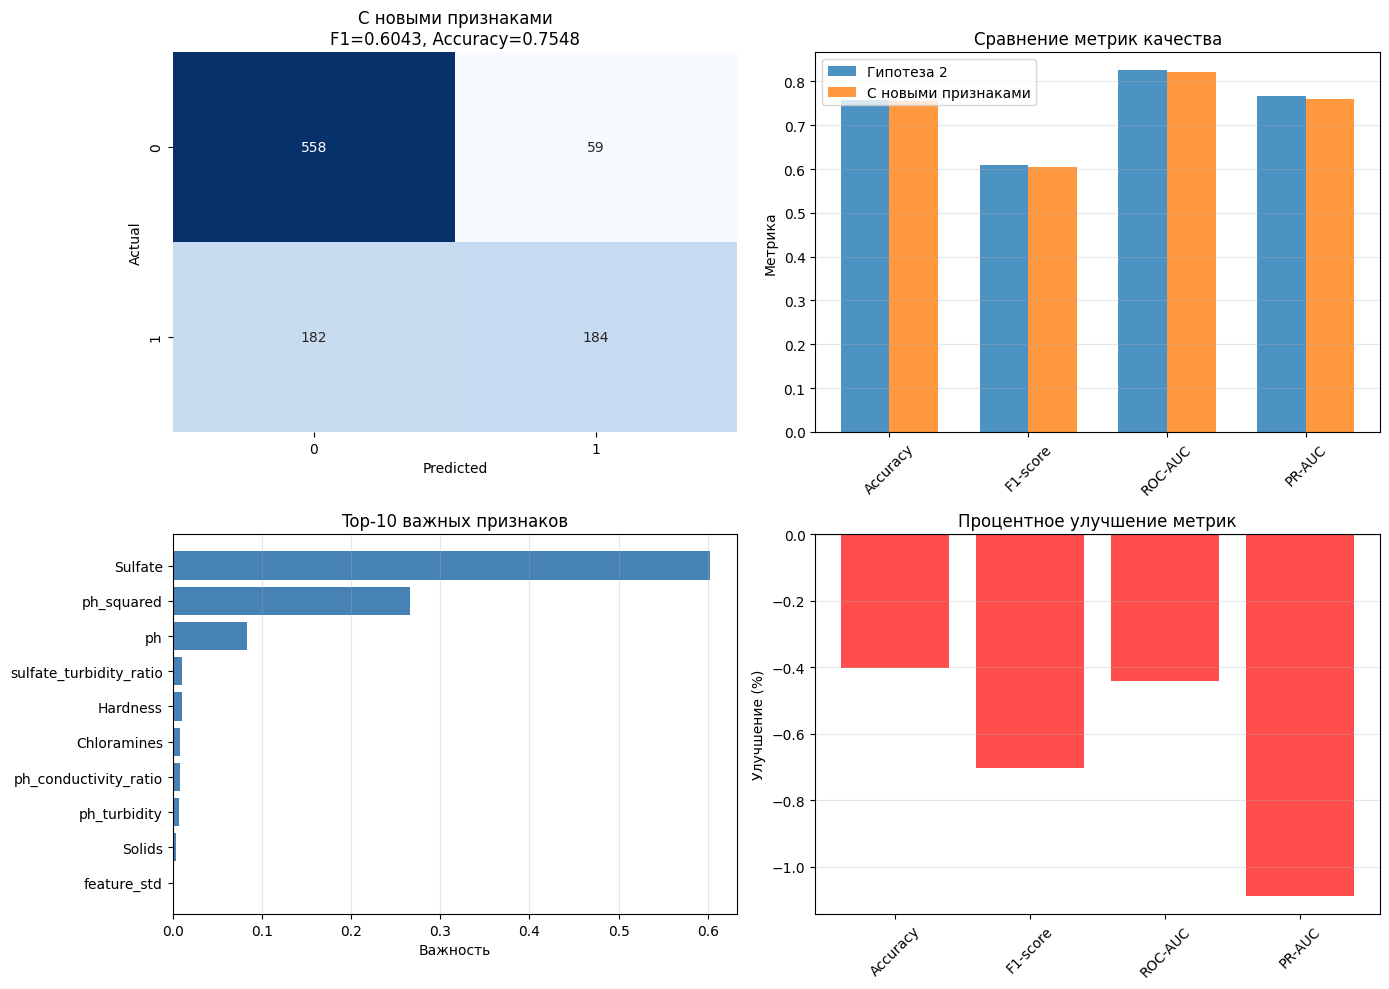

In [60]:
# Визуализация результатов инженерии признаков
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Матрица ошибок для модели с инженерией признаков
cm_fe = confusion_matrix(y_test_water_fe, y_pred_water_fe)
sns.heatmap(cm_fe, annot=True, fmt='d', ax=axes[0, 0], cmap='Blues', cbar=False)
axes[0, 0].set_title(f'С новыми признаками\nF1={f1_fe:.4f}, Accuracy={acc_fe:.4f}')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

# 2. Сравнение метрик
metrics_names = ['Accuracy', 'F1-score', 'ROC-AUC', 'PR-AUC']
hyp2_metrics = [acc_h2, f1_h2, roc_auc_h2, pr_auc_h2]
fe_metrics = [acc_fe, f1_fe, roc_auc_fe, pr_auc_fe]

x = np.arange(len(metrics_names))
width = 0.35

axes[0, 1].bar(x - width/2, hyp2_metrics, width, label='Гипотеза 2', alpha=0.8)
axes[0, 1].bar(x + width/2, fe_metrics, width, label='С новыми признаками', alpha=0.8)
axes[0, 1].set_ylabel('Метрика')
axes[0, 1].set_title('Сравнение метрик качества')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics_names, rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Важность признаков (Tree feature importance)
feature_importance = dt_clf_fe.feature_importances_
top_indices = np.argsort(feature_importance)[-10:]
top_features = [X_water_fe_extended.columns[i] for i in top_indices]
top_importance = feature_importance[top_indices]

axes[1, 0].barh(top_features, top_importance, color='steelblue')
axes[1, 0].set_xlabel('Важность')
axes[1, 0].set_title('Top-10 важных признаков')
axes[1, 0].grid(alpha=0.3, axis='x')

# 4. Улучшение метрик
improvement = [(fe_metrics[i] - hyp2_metrics[i]) / hyp2_metrics[i] * 100 
               for i in range(len(metrics_names))]
colors = ['green' if x > 0 else 'red' for x in improvement]
axes[1, 1].bar(metrics_names, improvement, color=colors, alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 1].set_ylabel('Улучшение (%)')
axes[1, 1].set_title('Процентное улучшение метрик')
axes[1, 1].set_xticklabels(metrics_names, rotation=45)
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

*Создание новых признаков не дало улучшений метрик модели решающего дерева для классификации. Пока гипотеза 2 лучше всего улучшает результаты.*

Создание новых признаков для задачи регрессии

In [ ]:
# загрузим данные заново для инженерии признаков
df_concrete_fe = pd.read_csv('concrete.csv', na_values=['', '?', 'N/A', 'NA', 'None', ' ', '-'])
df_concrete_fe = df_concrete_fe.fillna(df_concrete_fe.median())

X_concrete_fe = df_concrete_fe.iloc[:, :-1]
y_concrete_fe = df_concrete_fe.iloc[:, -1]

# создание новых признаков
X_concrete_fe_extended = X_concrete_fe.copy()

# взаимодействие признаков
X_concrete_fe_extended['cement_water'] = X_concrete_fe_extended['cement'] * X_concrete_fe_extended['water']
X_concrete_fe_extended['cement_slag'] = X_concrete_fe_extended['cement'] * X_concrete_fe_extended['slag']
X_concrete_fe_extended['cement_ash'] = X_concrete_fe_extended['cement'] * X_concrete_fe_extended['flyash']
X_concrete_fe_extended['slag_ash'] = X_concrete_fe_extended['slag'] * X_concrete_fe_extended['flyash']
X_concrete_fe_extended['water_superplasticizer'] = X_concrete_fe_extended['water'] * X_concrete_fe_extended['superplasticizer']

# полиномиальные признаки
X_concrete_fe_extended['cement_squared'] = X_concrete_fe_extended['cement'] ** 2
X_concrete_fe_extended['water_squared'] = X_concrete_fe_extended['water'] ** 2
X_concrete_fe_extended['slag_squared'] = X_concrete_fe_extended['slag'] ** 2
X_concrete_fe_extended['age_squared'] = X_concrete_fe_extended['age'] ** 2
X_concrete_fe_extended['age_cubed'] = X_concrete_fe_extended['age'] ** 3

# отношения между признаками (безопасность - деление на ноль)
X_concrete_fe_extended['cement_water_ratio'] = X_concrete_fe_extended['cement'] / (X_concrete_fe_extended['water'] + 1e-6)
X_concrete_fe_extended['total_binders'] = (X_concrete_fe_extended['cement'] + 
                                            X_concrete_fe_extended['slag'] + 
                                            X_concrete_fe_extended['flyash'])
X_concrete_fe_extended['binder_water_ratio'] = X_concrete_fe_extended['total_binders'] / (X_concrete_fe_extended['water'] + 1e-6)

# статистические признаки
X_concrete_fe_extended['component_mean'] = X_concrete_fe_extended[['cement', 'slag', 'flyash', 'water']].mean(axis=1)
X_concrete_fe_extended['component_max'] = X_concrete_fe_extended[['cement', 'slag', 'flyash', 'water']].max(axis=1)

print(f"Исходное количество признаков: {X_concrete_fe.shape[1]}")
print(f"Количество признаков после добавления: {X_concrete_fe_extended.shape[1]}")

Исходное количество признаков: 8
Количество признаков после добавления: 23


Обучение модели регрессии с новыми признаками

Метрики качества (с новыми признаками):
  MAE:   3.9894
  RMSE:  6.0019
  MSE:   36.0223
  R²:    0.8669

Метрики качества (гипотеза 2):
  MAE:   4.4604
  RMSE:  6.8768
  MSE:   47.2904
  R²:    0.8252


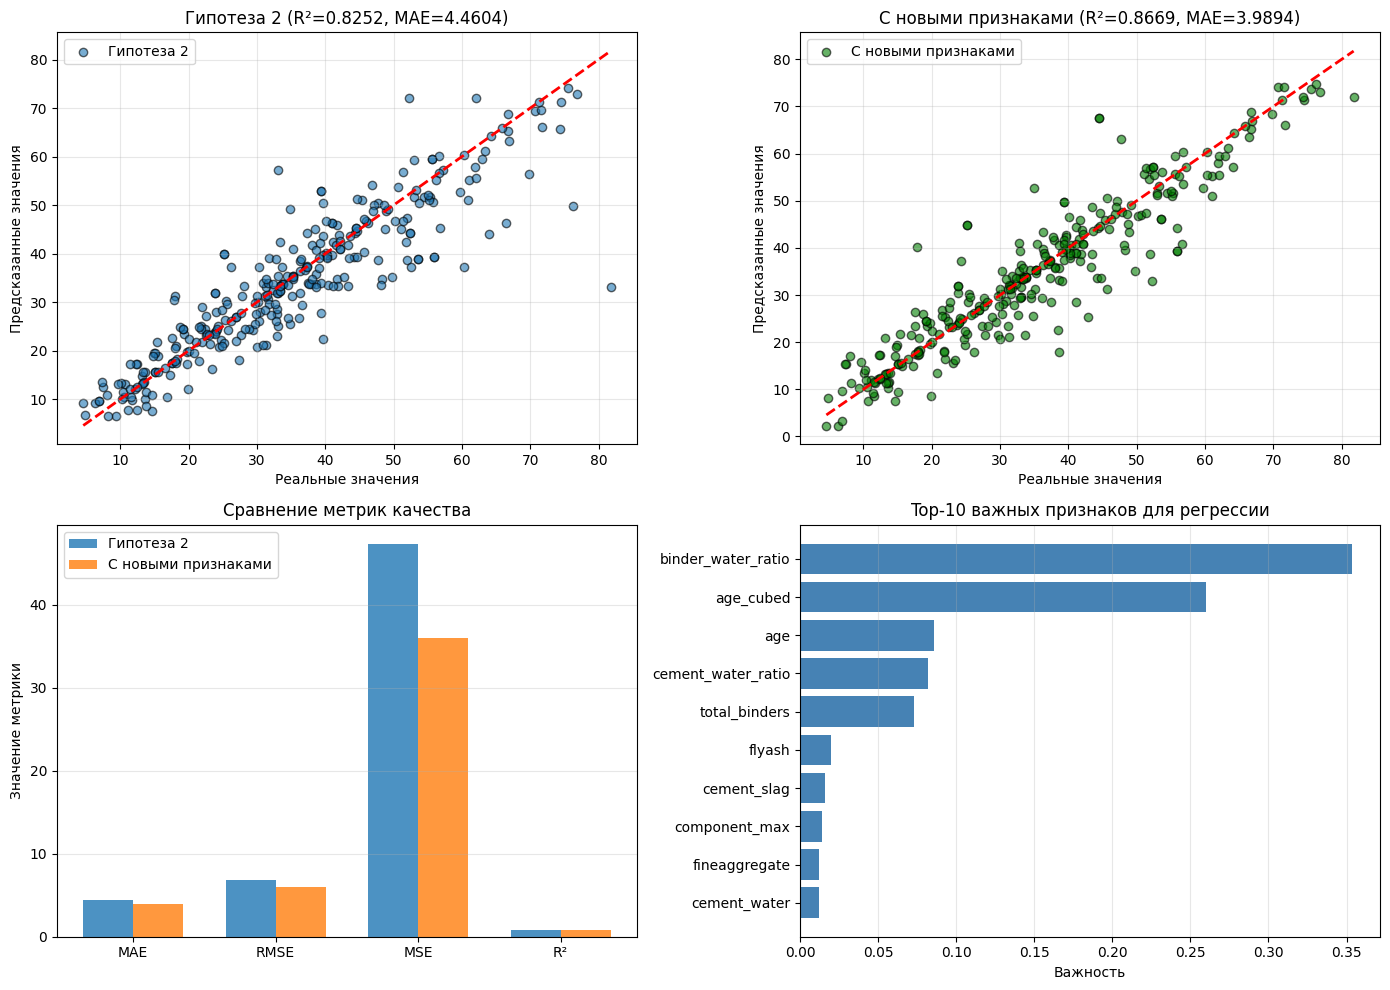

In [ ]:
# разделение на train/test с новыми признаками
X_train_concrete_fe, X_test_concrete_fe, y_train_concrete_fe, y_test_concrete_fe = train_test_split(
    X_concrete_fe_extended, y_concrete_fe, test_size=0.3, random_state=42
)

# обучение решающего дерева с новыми признаками и оптимальной глубиной
dt_reg_fe = DecisionTreeRegressor(max_depth=best_depth_reg, random_state=42)
dt_reg_fe.fit(X_train_concrete_fe, y_train_concrete_fe)
y_pred_concrete_fe = dt_reg_fe.predict(X_test_concrete_fe)

# вычисление метрик
mae_fe = mean_absolute_error(y_test_concrete_fe, y_pred_concrete_fe)
rmse_fe = np.sqrt(mean_squared_error(y_test_concrete_fe, y_pred_concrete_fe))
mse_fe = mean_squared_error(y_test_concrete_fe, y_pred_concrete_fe)
r2_fe = r2_score(y_test_concrete_fe, y_pred_concrete_fe)

print(f"Метрики качества (с новыми признаками):")
print(f"  MAE:   {mae_fe:.4f}")
print(f"  RMSE:  {rmse_fe:.4f}")
print(f"  MSE:   {mse_fe:.4f}")
print(f"  R²:    {r2_fe:.4f}")

print(f"\nМетрики качества (гипотеза 2):")
print(f"  MAE:   {mae_h2:.4f}")
print(f"  RMSE:  {rmse_h2:.4f}")
print(f"  MSE:   {mse_h2:.4f}")
print(f"  R²:    {r2_h2:.4f}")

# Визуализация результатов для регрессии
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. График предсказаний vs реальные значения (baseline)
axes[0, 0].scatter(y_test_concrete_h1, y_pred_concrete_h2, alpha=0.6, edgecolors='k', label='Гипотеза 2')
axes[0, 0].plot([y_test_concrete_h1.min(), y_test_concrete_h1.max()], 
                [y_test_concrete_h1.min(), y_test_concrete_h1.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Реальные значения')
axes[0, 0].set_ylabel('Предсказанные значения')
axes[0, 0].set_title(f'Гипотеза 2 (R²={r2_h2:.4f}, MAE={mae_h2:.4f})')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].legend()

# 2. График предсказаний vs реальные значения (с инженерией)
axes[0, 1].scatter(y_test_concrete_fe, y_pred_concrete_fe, alpha=0.6, edgecolors='k', color='green', label='С новыми признаками')
axes[0, 1].plot([y_test_concrete_fe.min(), y_test_concrete_fe.max()], 
                [y_test_concrete_fe.min(), y_test_concrete_fe.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Реальные значения')
axes[0, 1].set_ylabel('Предсказанные значения')
axes[0, 1].set_title(f'С новыми признаками (R²={r2_fe:.4f}, MAE={mae_fe:.4f})')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].legend()

# 3. Сравнение метрик
metrics_names_reg = ['MAE', 'RMSE', 'MSE', 'R²']
hyp2_metrics_reg = [mae_h2, rmse_h2, mse_h2, r2_h2]
fe_metrics_reg = [mae_fe, rmse_fe, mse_fe, r2_fe]

x = np.arange(len(metrics_names_reg))
width = 0.35

axes[1, 0].bar(x - width / 2, hyp2_metrics_reg, width, label='Гипотеза 2', alpha=0.8)
axes[1, 0].bar(x + width / 2, fe_metrics_reg, width, label='С новыми признаками', alpha=0.8)
axes[1, 0].set_ylabel('Значение метрики')
axes[1, 0].set_title('Сравнение метрик качества')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics_names_reg)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Важность признаков для регрессии
feature_importance_reg = dt_reg_fe.feature_importances_
top_indices_reg = np.argsort(feature_importance_reg)[-10:]
top_features_reg = [X_concrete_fe_extended.columns[i] for i in top_indices_reg]
top_importance_reg = feature_importance_reg[top_indices_reg]

axes[1, 1].barh(top_features_reg, top_importance_reg, color='steelblue')
axes[1, 1].set_xlabel('Важность')
axes[1, 1].set_title('Top-10 важных признаков для регрессии')
axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

*После создания новых признаков, модель регресии показала небольшое улучшение метрик по сравнению с гипотезой 2.*

### 3c-f. Формирование улучшенного бейзлайна

Выведем метрики для базовых и улучшенных моделей классификации и регрессии.

In [70]:
print("Метрики классификации:")
print(f"baseline:   Accuracy={accuracy:.4f}, F1={f1:.4f}, ROC-AUC={roc_auc:.4f}, PR-AUC={pr_auc:.4f}")
print(f"Гипотеза 2: Accuracy={acc_h2:.4f}, F1={f1_h2:.4f}, ROC-AUC={roc_auc_h2:.4f}, PR-AUC={pr_auc_h2:.4f}")
print(f"Гипотеза 3: Accuracy={acc_h3:.4f}, F1={f1_h3:.4f}, ROC-AUC={roc_auc_h3:.4f}, PR-AUC={pr_auc_h3:.4f}")

print("\nМетрики регрессии:")
print(f"baseline:    MAE={mae:.4f}, R²={r2:.4f}, MSE={mse:.4f}")
print(f"Гипотеза 2:  MAE={mae_h2:.4f}, R²={r2_h2:.4f}, MSE={mse_h2:.4f}")
print(f"Гипотеза 5:  MAE={mae_fe:.4f}, R²={r2_fe:.4f}, MSE={mse_fe:.4f}")

Метрики классификации:
baseline:   Accuracy=0.6043, F1=0.4724, ROC-AUC=0.6443, PR-AUC=0.5574
Гипотеза 2: Accuracy=0.7579, F1=0.6086, ROC-AUC=0.8257, PR-AUC=0.7676
Гипотеза 3: Accuracy=0.7609, F1=0.6129, ROC-AUC=0.8306, PR-AUC=0.7760

Метрики регрессии:
baseline:    MAE=7.6459, R²=0.6188, MSE=103.1342
Гипотеза 2:  MAE=4.4604, R²=0.8252, MSE=47.2904
Гипотеза 5:  MAE=3.9894, R²=0.8669, MSE=36.0223


### 3g. Выводы

Проанализировав различные гипотезы для улучшения качества решающего дерева, можно сделать следующие выводы:

**Для классификации:**

Заполнение пропусков медианой, ограничение глубины дерева и подбор параметров `min_samples_split` и `min_samples_leaf` способствуют улучшению метрик и снижению риска переобучения. Создание новых признаков и масштабирование не улучшило метрики классификации.

Улучшенный baseline: гипотезы 1 + 2 + 3.

**Для регрессии:**

Подбор глубины решающего дерева помог получить более стабильные прогнозы и улучшить качество на тестовой выборке. Создание новых признаков, особенно взаимодействий между компонентами бетона и возрастом, значительно улучшило $R^2$ значение модели. Масштабирование, подбор параметров `min_samples_split` и `min_samples_leaf` не дали значительных улучшений.

Улучшенный baseline: гипотезы 2 + 5.

## 4. Имплементация алгоритма решающего дерева

### 4a. Реализация алгоритма

Реализация решающего дерева для задачи классификации.

In [ ]:
import numpy as np

class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, class_probs=None):
        self.feature = feature  # индекс признака для сплита
        self.threshold = threshold  # пороговое значение
        self.left = left # левое поддерево
        self.right = right # правое поддерево
        self.class_probs = class_probs  # вероятности классов в листе (массив длины n_classes)

class DecisionTreeClassifierCustom:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, n_classes=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.n_classes = n_classes  # важно для bincount

    def _gini(self, y):
        """ Вычисление индекса Джини для массива меток y """
        if len(y) == 0:
            return 0.0
        counts = np.bincount(y, minlength=self.n_classes) # количество образцов каждого класса
        probs = counts / len(y) # вероятности классов
        return 1.0 - np.sum(probs ** 2)

    def _best_split(self, X, y):
        """ Нахождение лучшего сплита для узла """
        best_gain = -1
        best_feat, best_thr = None, None
        n_samples = len(y)
        parent_gini = self._gini(y)

        for feat in range(X.shape[1]):
            thresholds = np.unique(X[:, feat]) # выбираем уникальные пороги
            for thr in thresholds:
                left_mask = X[:, feat] <= thr # логическая маска для левой ветви
                right_mask = ~left_mask # логическая маска для правой ветви
                n_left, n_right = np.sum(left_mask), np.sum(right_mask) # количество образцов в каждой ветви

                # Проверяем ограничения
                if (n_left < self.min_samples_leaf or 
                    n_right < self.min_samples_leaf or
                    n_left + n_right < self.min_samples_split):
                    continue

                gini_left = self._gini(y[left_mask]) # индекс Джини для левой ветви
                gini_right = self._gini(y[right_mask])  # индекс Джини для правой ветви
                weighted_gini = (n_left * gini_left + n_right * gini_right) / n_samples # взвешенный индекс Джини
                gain = parent_gini - weighted_gini # прирост Джини

                if gain > best_gain: # обновляем лучший сплит
                    best_gain, best_feat, best_thr = gain, feat, thr

        return best_feat, best_thr

    def _build_tree(self, X, y, depth=0):
        # Условия остановки → создаём лист
        if (
            len(y) < self.min_samples_split or
            len(np.unique(y)) == 1 or
            (self.max_depth is not None and depth >= self.max_depth)
        ):
            counts = np.bincount(y, minlength=self.n_classes)
            probs = counts / counts.sum()
            return TreeNode(class_probs=probs)

        feat, thr = self._best_split(X, y)
        if feat is None:
            counts = np.bincount(y, minlength=self.n_classes)
            probs = counts / counts.sum()
            return TreeNode(class_probs=probs)

        left_mask = X[:, feat] <= thr # логическая маска для левой ветви
        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1) # рекурсивное построение левой ветви
        right_subtree = self._build_tree(X[~left_mask], y[~left_mask], depth + 1) # рекурсивное построение правой ветви

        return TreeNode(feature=feat, threshold=thr, left=left_subtree, right=right_subtree)

    def fit(self, X, y):
        X, y = np.asarray(X), np.asarray(y)
        self.n_classes = len(np.unique(y))  # автоматическое определение числа классов
        self.tree_ = self._build_tree(X, y)
        return self

    def _predict_sample(self, x, node):
        if node.class_probs is not None:
            return np.argmax(node.class_probs)  # жёсткое предсказание
        if x[node.feature] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)

    def _predict_proba_sample(self, x, node):
        if node.class_probs is not None:
            return node.class_probs
        if x[node.feature] <= node.threshold:
            return self._predict_proba_sample(x, node.left)
        else:
            return self._predict_proba_sample(x, node.right)

    def predict(self, X):
        """ Возвращает предсказанные классы для каждого образца """
        X = np.asarray(X)
        return np.array([self._predict_sample(x, self.tree_) for x in X])

    def predict_proba(self, X):
        """ Возвращает вероятности классов для каждого образца """
        X = np.asarray(X)
        return np.array([self._predict_proba_sample(x, self.tree_) for x in X])

Реализация решающего дерева для задачи регрессии.

In [ ]:
class TreeNodeReg:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature # индекс признака для сплита
        self.threshold = threshold # порог
        self.left = left # левое поддерево
        self.right = right # правое поддерево
        self.value = value # предсказываемое значение (среднее y в листе)

class DecisionTreeRegressorCustom:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth # глубина дерева
        self.min_samples_split = min_samples_split # мин. число образцов для сплита
        self.min_samples_leaf = min_samples_leaf # мин. число образцов в листе

    def _mse(self, y):
        """ Вычисление среднеквадратичной ошибки"""
        if len(y) == 0:
            return 0.0
        return np.mean((y - np.mean(y)) ** 2)

    def _best_split(self, X, y):
        """ Нахождение лучшего сплита по MSE """
        best_reduction = -1
        best_feat, best_thr = None, None
        n_samples = len(y)
        parent_mse = self._mse(y)

        for feat in range(X.shape[1]):
            thresholds = np.unique(X[:, feat]) # выбор порогов
            for thr in thresholds:
                left_mask = X[:, feat] <= thr
                right_mask = ~left_mask
                n_left, n_right = np.sum(left_mask), np.sum(right_mask)

                # Проверка ограничений
                if (n_left < self.min_samples_leaf or 
                    n_right < self.min_samples_leaf or
                    n_left + n_right < self.min_samples_split):
                    continue

                mse_left = self._mse(y[left_mask])
                mse_right = self._mse(y[right_mask])
                weighted_mse = (n_left * mse_left + n_right * mse_right) / n_samples
                reduction = parent_mse - weighted_mse  # MSE уменьшается при хорошем сплите

                if reduction > best_reduction:
                    best_reduction, best_feat, best_thr = reduction, feat, thr

        return best_feat, best_thr

    def _build_tree(self, X, y, depth=0):
        # Условия остановки → создаём лист
        if (
            len(y) < self.min_samples_split or
            (self.max_depth is not None and depth >= self.max_depth)
        ):
            return TreeNodeReg(value=np.mean(y))

        feat, thr = self._best_split(X, y)
        if feat is None:
            return TreeNodeReg(value=np.mean(y))

        left_mask = X[:, feat] <= thr
        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[~left_mask], y[~left_mask], depth + 1)

        return TreeNodeReg(feature=feat, threshold=thr, left=left_subtree, right=right_subtree)

    def fit(self, X, y):
        X, y = np.asarray(X), np.asarray(y)
        self.tree_ = self._build_tree(X, y)
        return self

    def _predict_sample(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)

    def predict(self, X):
        X = np.asarray(X)
        return np.array([self._predict_sample(x, self.tree_) for x in X])

### 4b. Обучение собственной реализации и оценка качества

Обучение и оценка качества модели классификации

In [95]:
df_water = pd.read_csv('water_potability.csv', na_values=['', '?', 'N/A', 'NA', 'None', ' ', '-'], index_col=0)

df_water_cu = df_water.dropna()

X_water_cu = df_water_cu.drop('Potability', axis=1)
y_water_cu = df_water_cu['Potability']

X_train_water_cu, X_test_water_cu, y_train_water_cu, y_test_water_cu = train_test_split(
    X_water_cu, y_water_cu, test_size=0.3, random_state=42
)


# Обучение собственной реализации на baseline данных
dt_custom_clf_baseline = DecisionTreeClassifierCustom(max_depth=4)
dt_custom_clf_baseline.fit(X_train_water_cu, y_train_water_cu)
y_pred_custom_clf_baseline = dt_custom_clf_baseline.predict(X_test_water_cu.values)
y_pred_proba_clf_baseline = dt_custom_clf_baseline.predict_proba(X_test_water_cu.values)[:, 1]

dt_sklearn_clf_baseline = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_sklearn_clf_baseline.fit(X_train_water_cu, y_train_water_cu)
y_pred_sklearn_clf_baseline = dt_sklearn_clf_baseline.predict(X_test_water_cu)
y_pred_proba_sklearn_baseline = dt_sklearn_clf_baseline.predict_proba(X_test_water_cu)[:, 1]

# Метрики для классификации
acc_custom_baseline = accuracy_score(y_test_water_cu, y_pred_custom_clf_baseline)
f1_custom_baseline = f1_score(y_test_water_cu, y_pred_custom_clf_baseline, zero_division=0)
roc_auc_custom_baseline = roc_auc_score(y_test_water_cu, y_pred_custom_clf_baseline)
precision_custom, recall_custom, _ = precision_recall_curve(y_test_water_cu, y_pred_proba_clf_baseline)
pr_auc_custom_baseline = auc(recall_custom, precision_custom)

acc_sklearn_baseline = accuracy_score(y_test_water_cu, y_pred_sklearn_clf_baseline)
f1_sklearn_baseline = f1_score(y_test_water_cu, y_pred_sklearn_clf_baseline, zero_division=0)
roc_auc_sklearn_baseline = roc_auc_score(y_test_water_cu, y_pred_sklearn_clf_baseline)
precision_sklearn, recall_sklearn, _ = precision_recall_curve(y_test_water_cu, y_pred_proba_sklearn_baseline)
pr_auc_sklearn_baseline = auc(recall_sklearn, precision_sklearn)

print("Классификация (собственная реализация - baseline):")
print(f"  Accuracy:  {acc_custom_baseline:.4f}")
print(f"  F1-score:  {f1_custom_baseline:.4f}")
print(f"  ROC-AUC:   {roc_auc_custom_baseline:.4f}")
print(f"  PR-AUC:    {pr_auc_custom_baseline:.4f}")

print("\nКлассификация (sklearn реализация - baseline):")
print(f"  Accuracy:  {acc_sklearn_baseline:.4f}")
print(f"  F1-score:  {f1_sklearn_baseline:.4f}")
print(f"  ROC-AUC:   {roc_auc_sklearn_baseline:.4f}")
print(f"  PR-AUC:    {pr_auc_sklearn_baseline:.4f}")

Классификация (собственная реализация - baseline):
  Accuracy:  0.6026
  F1-score:  0.4690
  ROC-AUC:   0.5762
  PR-AUC:    0.5520

Классификация (sklearn реализация - baseline):
  Accuracy:  0.6043
  F1-score:  0.4724
  ROC-AUC:   0.5782
  PR-AUC:    0.5574


*Метрики практически совпали, значит модель релаизована верно.*

Обучение и оценка качества модели регрессии

In [94]:
# Обучение для регрессии
dt_custom_reg_baseline = DecisionTreeRegressorCustom(max_depth=4)
dt_custom_reg_baseline.fit(X_train_concrete.values, y_train_concrete.values)
y_pred_custom_reg_baseline = dt_custom_reg_baseline.predict(X_test_concrete.values)

dt_sklearn_reg_baseline = DecisionTreeRegressor(max_depth=4, random_state=42)
dt_sklearn_reg_baseline.fit(X_train_concrete, y_train_concrete)
y_pred_sklearn_reg_baseline = dt_sklearn_reg_baseline.predict(X_test_concrete)

# Метрики для регрессии
mae_custom_baseline = mean_absolute_error(y_test_concrete, y_pred_custom_reg_baseline)
r2_custom_baseline = r2_score(y_test_concrete, y_pred_custom_reg_baseline)
mse_custom_baseline = mean_squared_error(y_test_concrete, y_pred_custom_reg_baseline)

mae_sklearn_baseline = mean_absolute_error(y_test_concrete, y_pred_sklearn_reg_baseline)
r2_sklearn_baseline = r2_score(y_test_concrete, y_pred_sklearn_reg_baseline)
mse_sklearn_baseline = mean_squared_error(y_test_concrete, y_pred_sklearn_reg_baseline)

print("\nРегрессия (собственная реализация - baseline):")
print(f"  MAE:  {mae_custom_baseline:.4f}")
print(f"  R²:   {r2_custom_baseline:.4f}")
print(f"  MSE:  {mse_custom_baseline:.4f}")

print("\nРегрессия (sklearn реализация - baseline):")
print(f"  MAE:  {mae_sklearn_baseline:.4f}")
print(f"  R²:   {r2_sklearn_baseline:.4f}")
print(f"  MSE:  {mse_sklearn_baseline:.4f}")


Регрессия (собственная реализация - baseline):
  MAE:  7.7076
  R²:   0.6147
  MSE:  104.2526

Регрессия (sklearn реализация - baseline):
  MAE:  7.6459
  R²:   0.6188
  MSE:  103.1342


*Решающее дерево для классификации дало почти такие же метрики, что и реализация sklearn. В имплементации несколько другой способ выбора порогов, отсутсвие численной устройчивости и оптимизации.*

### 4c. Обучение собственной реализации на улучшенных данных и оценка качества

Обучение и оценка качества модели классификации на улучшенных данных

Классификация (собственная реализация - улучшенные данные):
  Accuracy:  0.7599
  F1-score:  0.6118
  ROC-AUC:   0.7087
  PR-AUC:    0.7780

Классификация (sklearn реализация - улучшенные данные):
  Accuracy:  0.7609
  F1-score:  0.6129
  ROC-AUC:   0.7095
  PR-AUC:    0.7760


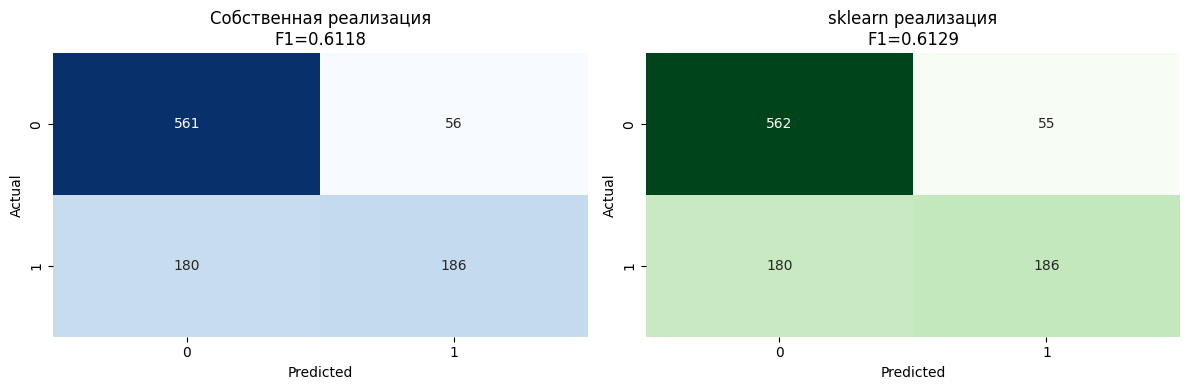

In [ ]:
dt_custom_clf_improved = DecisionTreeClassifierCustom(max_depth=best_depth, min_samples_split=20, min_samples_leaf=4)
dt_custom_clf_improved.fit(X_train_water_h1, y_train_water_h1)
y_pred_custom_clf_improved = dt_custom_clf_improved.predict(X_test_water_h1.values)
y_pred_proba_clf_improved = dt_custom_clf_improved.predict_proba(X_test_water_h1.values)[:, 1]

# sklearn
dt_sklearn_clf_improved = DecisionTreeClassifier(max_depth=best_depth, random_state=42, min_samples_split=20, min_samples_leaf=4)
dt_sklearn_clf_improved.fit(X_train_water_h1, y_train_water_h1)
y_pred_sklearn_clf_improved = dt_sklearn_clf_improved.predict(X_test_water_h1)
y_pred_proba_sklearn_improved = dt_sklearn_clf_improved.predict_proba(X_test_water_h1)[:, 1]

# Метрики для классификации
acc_custom_improved = accuracy_score(y_test_water_h1, y_pred_custom_clf_improved)
f1_custom_improved = f1_score(y_test_water_h1, y_pred_custom_clf_improved, zero_division=0)
roc_auc_custom_improved = roc_auc_score(y_test_water_h1, y_pred_custom_clf_improved)
precision_custom_improved, recall_custom_improved, _ = precision_recall_curve(y_test_water_h1, y_pred_proba_clf_improved)
pr_auc_custom_improved = auc(recall_custom_improved, precision_custom_improved)

acc_sklearn_improved = accuracy_score(y_test_water_h1, y_pred_sklearn_clf_improved)
f1_sklearn_improved = f1_score(y_test_water_h1, y_pred_sklearn_clf_improved, zero_division=0)
roc_auc_sklearn_improved = roc_auc_score(y_test_water_h1, y_pred_sklearn_clf_improved)
precision_sklearn_improved, recall_sklearn_improved, _ = precision_recall_curve(y_test_water_h1, y_pred_proba_sklearn_improved)
pr_auc_sklearn_improved = auc(recall_sklearn_improved, precision_sklearn_improved)

print(f"Классификация (собственная реализация - улучшенные данные):")
print(f"  Accuracy:  {acc_custom_improved:.4f}")
print(f"  F1-score:  {f1_custom_improved:.4f}")
print(f"  ROC-AUC:   {roc_auc_custom_improved:.4f}")
print(f"  PR-AUC:    {pr_auc_custom_improved:.4f}")

print(f"\nКлассификация (sklearn реализация - улучшенные данные):")
print(f"  Accuracy:  {acc_sklearn_improved:.4f}")
print(f"  F1-score:  {f1_sklearn_improved:.4f}")
print(f"  ROC-AUC:   {roc_auc_sklearn_improved:.4f}")
print(f"  PR-AUC:    {pr_auc_sklearn_improved:.4f}")

# Визуализация матриц ошибок
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cm_custom = confusion_matrix(y_test_water_fe, y_pred_custom_clf_improved)
sns.heatmap(cm_custom, annot=True, fmt='d', ax=axes[0], cmap='Blues', cbar=False)
axes[0].set_title(f'Собственная реализация\nF1={f1_custom_improved:.4f}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

cm_sklearn = confusion_matrix(y_test_water_fe, y_pred_sklearn_clf_improved)
sns.heatmap(cm_sklearn, annot=True, fmt='d', ax=axes[1], cmap='Greens', cbar=False)
axes[1].set_title(f'sklearn реализация\nF1={f1_sklearn_improved:.4f}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

Обучение и оценка качества модели классификации на улучшенных данных


Регрессия (собственная реализация - улучшенные данные):
  MAE:   4.2664
  RMSE:  6.4244
  R²:    0.8475

Регрессия (sklearn реализация - улучшенные данные):
  MAE:   3.9894
  RMSE:  6.0019
  R²:    0.8669


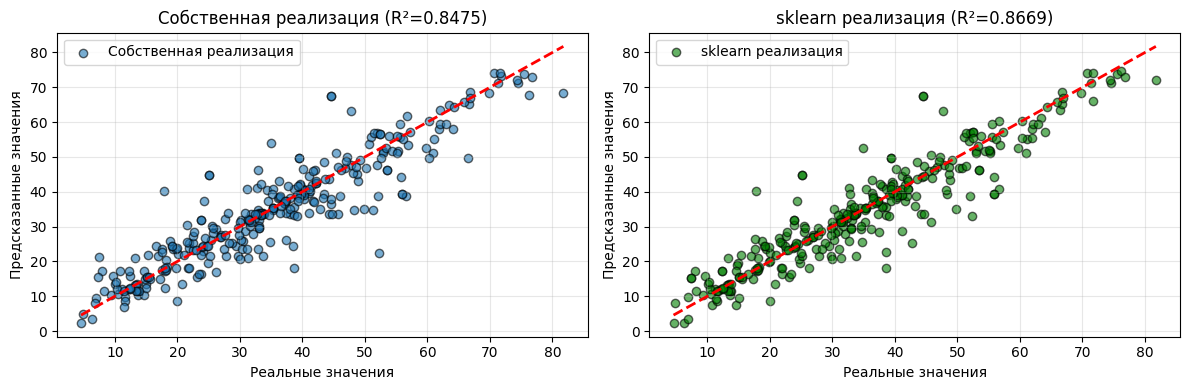

In [ ]:
dt_custom_reg_improved = DecisionTreeRegressorCustom(max_depth=best_depth_reg)
dt_custom_reg_improved.fit(X_train_concrete_fe.values, y_train_concrete_fe.values)
y_pred_custom_reg_improved = dt_custom_reg_improved.predict(X_test_concrete_fe.values)

dt_sklearn_reg_improved = DecisionTreeRegressor(max_depth=best_depth_reg, random_state=42)
dt_sklearn_reg_improved.fit(X_train_concrete_fe, y_train_concrete_fe)
y_pred_sklearn_reg_improved = dt_sklearn_reg_improved.predict(X_test_concrete_fe)

# Метрики для регрессии
mae_custom_improved = mean_absolute_error(y_test_concrete_fe, y_pred_custom_reg_improved)
rmse_custom_improved = np.sqrt(mean_squared_error(y_test_concrete_fe, y_pred_custom_reg_improved))
r2_custom_improved = r2_score(y_test_concrete_fe, y_pred_custom_reg_improved)

mae_sklearn_improved = mean_absolute_error(y_test_concrete_fe, y_pred_sklearn_reg_improved)
rmse_sklearn_improved = np.sqrt(mean_squared_error(y_test_concrete_fe, y_pred_sklearn_reg_improved))
r2_sklearn_improved = r2_score(y_test_concrete_fe, y_pred_sklearn_reg_improved)

print(f"\nРегрессия (собственная реализация - улучшенные данные):")
print(f"  MAE:   {mae_custom_improved:.4f}")
print(f"  RMSE:  {rmse_custom_improved:.4f}")
print(f"  R²:    {r2_custom_improved:.4f}")

print(f"\nРегрессия (sklearn реализация - улучшенные данные):")
print(f"  MAE:   {mae_sklearn_improved:.4f}")
print(f"  RMSE:  {rmse_sklearn_improved:.4f}")
print(f"  R²:    {r2_sklearn_improved:.4f}")


fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# собственная реализация
axes[0].scatter(y_test_concrete_fe, y_pred_custom_reg_improved, alpha=0.6, edgecolors='k', label='Собственная реализация')
axes[0].plot([y_test_concrete_fe.min(), y_test_concrete_fe.max()], 
             [y_test_concrete_fe.min(), y_test_concrete_fe.max()], 'r--', lw=2)
axes[0].set_xlabel('Реальные значения')
axes[0].set_ylabel('Предсказанные значения')
axes[0].set_title(f'Собственная реализация (R²={r2_custom_improved:.4f})')
axes[0].grid(alpha=0.3)
axes[0].legend()

# sklearn реализация
axes[1].scatter(y_test_concrete_fe, y_pred_sklearn_reg_improved, alpha=0.6, edgecolors='k', color='green', label='sklearn реализация')
axes[1].plot([y_test_concrete_fe.min(), y_test_concrete_fe.max()], 
             [y_test_concrete_fe.min(), y_test_concrete_fe.max()], 'r--', lw=2)
axes[1].set_xlabel('Реальные значения')
axes[1].set_ylabel('Предсказанные значения')
axes[1].set_title(f'sklearn реализация (R²={r2_sklearn_improved:.4f})')
axes[1].grid(alpha=0.3)
axes[1].legend()
plt.tight_layout()
plt.show()

*Можем заметить, что метрики имплементации немного отличаются от метрик sklearn реализации. Метрики стали лучше по сравнению с baseline обучением. Значит, реализации модели регрессии корректна.*

### 4j. Выводы

В данной лабораторной работе была реализована алгоритм решающего дерева (Decision Tree) с нуля для задач классификации и регрессии, а также проведено сравнение с реализацией из библиотеки sklearn.

Решающее дерево для классификации строится рекурсивным разбиением обучающей выборки на подмножества по признакам, минимизируя неоднородность (используется индекс Джини) в узлах. В каждом листе сохраняется распределение классов, что позволяет возвращать как жёсткие предсказания, так и вероятности. Остановка роста дерева регулируется гиперпараметрами: максимальной глубиной (`max_depth`), минимальным числом объектов для разбиения (`min_samples_split`) и в листе (`min_samples_leaf`).

Решающее дерево для регрессии использует ту же рекурсивную стратегию, но в качестве критерия качества разбиения применяется снижение среднеквадратичной ошибки (`MSE`). В каждом листе сохраняется среднее значение целевой переменной, которое и выдаётся как предсказание для новых объектов, попавших в этот лист. Управление сложностью модели осуществляется теми же гиперпараметрами, что и в классификаторе.

Метрики модели решающего дерева лучше метрик моделей KNN и Logistic/LinReg. Это говорит о том, что решшающего дерева лучше работает с дисбалансом классов и нелинейными зависимостями в данных.